<a href="https://colab.research.google.com/github/ktichola/ML-and-DL-to-Gravitational-waves-analysis/blob/main/3_ML_Predicting_Pulsars.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'pulsar-star:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F110566%2F264393%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240505%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240505T104203Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D9b5ffe7ea4a5057c20e249c0d12028433427a9db7f1e3bced139150b8c43c03f293d1da86cae4b9951e0bcb7534d3c784f5b78520ca146c8b40355f1babc7202e2dfb94e455c487f8733b24748ab60006d43485798fa5a66e52b4eaf38919f6e694622154a25406b51681df44b7d145ccaeb6ee30adf28cdb60d2bfa914cd13b1d8efea6bf2a6bdcab81c56e2f3af155bd3721b72dbeb83ec66a16b75acd97b2f332a2ea89fd5c0b261a4c79c48785f6394d0fa8341d96925cf84d65b9da13b7fd4e062e5ded346c55969297d72dc015197710ec444d8c63ee9a9ae784b468a9fe3a333e9fb7cbc1949be9f8d23698b5de5c9fc195f6117f9643660d419937ee'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


# Predicting Pulsars
### Stellar Classification With Machine Learning

# Table of Contents
#### Data Science Workflow
An introduction and summary of the approach I took to complete this project
#### Business Case and Business Value  
Background  
Key question asked about the dataset  
#### Obtaining The Data
Sourcing the data  
Importing the CSV  
#### Scrubbing The Data
Explore potential missing values  
Ensure columns are of the correct data types  
Copy the dataset to later normalize  
#### Exploring The Data
Use basic plots to visually examine relationships within the dataset  
Exploration and familiarization with the dataset through statistical analysis  
Detecting potential skews  
Investigating possible multicollinearity   
#### Modeling The Data
Train and test split the data  
Create a baseline model to work up from  
Model the non-transformed data and review results   
Model the normalized & transformed data and compare results to the non-transformed    
Create multiple types of models to see what is the most accurate, efficient, and informative   
Tune hyperparameters to find the ideal parameters for best performing model  
#### Interpreting The Data
Compare the models created in the last step and weigh the pros & cons of each type  
Review the findings table to see which model is best, depending on our goals(accuracy, computational efficiency, etc)  
#### Conclusion
Expand upon our model review from the interpretation stage  
Conclusion and opinion on my ideal model    
Potential future work  
References

## Data Science Workflow
##### For this project I am going to use the OSEMiN process
##### (Obtain, Scrub, Explore, Model, Interpret)

- **Obtain** - This part was simple for this project, my dataset is Dr Robert Lyon's Predicting a Pulsar Star dataset from Kaggle: (https://www.kaggle.com/pavanraj159/predicting-a-pulsar-star/data)
- **Scrub** - The objective here is to identify errors, potential missing or corrupted fields in the data, and to clean up the dataset by discarding, replacing, or filling missing values and errors.
- **Explore** - This is largely what EDA is. The goal in this phase is to understand patterns within our dataset by visualizing and testing to examine relationships in the data.
- **Model** - This step encompases the higher level pre-processing such as normalization and synthetic oversampling of the minority class. After that we're ready to train some models to be able to give us some accurate predictive power to make intelligent business decisions. There are multiple steps of evaluation and refining of the models to ensure they're as accurate and unbiased as possible.
- **Interpret** - In the final step, we examine our findings developed by our modeling and indentify important insights. As more data becomes available, this cycle can repeat and continue in a loop to build a faster, less biased, and more accurate model.

Below you can follow the different stages of the EDA and modeling process by scrolling to the respective title.

## Business Case
#### Background
For this project, I assumed the role of a Data Scientist working with an astronomical research agency to train a machine learning model to classify whether a star is a pulsar or not.  
A pulsar is a rotating, magnetized Neutron star that emits radiation(mostly radio, X-ray, and gamma wavelength) from its poles. Other than black holes, pulsars are the most dense objects in the known universe. Pulsars rotate with a very short and precise period which vary from star to star, however due to Radio Frequency Interference and background radiation noise, there are many false-positives when attempting to detect pulsars.  
For further reading on pulsars visit the Wikipedia page [here](https://en.wikipedia.org/wiki/Pulsar).

#### Overall Goal:  
The goal is to train a machine learning model to classify pulsar candidate stars as either a true pulsar, or a false positive.
The overall goal is model accuracy, as computational cost is not of concern in this application.  


## Business Value  
### Why is this important?
#### Labor
In the most basic way, the ability to effectively train a machine learning algorithm to accurately classify a pulsar from a false positive would free up human assets to be able to complete other tasks. Astronomers are highly educated, and therefore, generally well paid. Freeing up these monetary assets allows them to be productive elsewhere.  
#### Cutting edge scientific discovery
Pulsars prove to be very helpful for physicists and astronomers for a variety of other reasons. Being able to quickly and effectively identify pulsars would allow more of them to be discovered and used for other types of experiments.  
Research on Pulsars has already yeilded two Nobel Peace Prizes. Pulsar research is at the tip of the spear in humanity's quest to understand gravitational waves and relativistic physics.  
#### Gravitational waves
Observing the precisely timed pulses from various pulsars scattered across the galaxy, astronomers aim to measure the slight variations in their signals which are thought to be caused by gravitational waves. Pulsar timing arrays are being used to uncover secrets of the early universe by hopefully confirming the observation of gravitational waves caused by pairs of supermassive black holes in the early universe, multidimensional strings, quasars, and other possible events from the first few moments following the Big Bang.  
#### Nuclear physics  
With pulsars being very small stellar objects(~10km radius) but having an average mass of ~1.4 solar masses, they are incredibly dense. In fact, the density of a pulsar is several times greater than the density of atomic nuclei. There is little understood about the physics of what goes on inside a pulsar and therefore are an incredibly interesting phenomena for physicists.
#### Mapping interstellar space
Due to the regularity of the emissions from pulsars, they can be used to triangulate position in the galaxy. Humanity has included pulsar maps on the two Pioneer plaques in addition to the Voyager Golden Record. These maps use 14 pulsars, and the position of the Sun to show where we are on the galactic plane. This form of navigation could prove to be very useful as Humanity progresses to a Type II civilization(see: [Kardashev Scale](https://en.wikipedia.org/wiki/Kardashev_scale)).
#### Measuring time
Again, using the regularity of a pulsar's pulses one can measure the passing of time, specifically establishing Ephemeris time which is free of the irregular constraints related to fluctuating mean solar time. Although pulsars are very precise and regular, the interference in the readings make this form of time measurement slightly less accurate and dependable when compared to an atomic clock - this however may change as our radio telescopes become more advanced.  

# Obtain the Data  
For this project, I used Dr Robert Lyon's Predicting a Pulsar Star dataset. Also included in this step will be the importing of any libraries I'll need throughout all the steps of my analysis and modeling.

In [ ]:
# import necessary tools
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import seaborn as sns
sns.set(style='darkgrid')

import itertools
import math
import time

import statsmodels.formula.api as smf
import xgboost as xgb
from xgboost import XGBClassifier
from scipy import stats
from sklearn import svm
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, \
    roc_curve, auc, mean_squared_error, roc_auc_score, recall_score, precision_score, \
    plot_confusion_matrix
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, \
    GradientBoostingClassifier, BaggingClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

import warnings
warnings.filterwarnings('ignore')

In [ ]:
data = pd.read_csv('../input/pulsar-star/pulsar_stars.csv')
data.head()

,Mean of the integrated profile,Standard deviation of the integrated profile,Excess kurtosis of the integrated profile,Skewness of the integrated profile,Mean of the DM-SNR curve,Standard deviation of the DM-SNR curve,Excess kurtosis of the DM-SNR curve,Skewness of the DM-SNR curve,target_class
0,140.562500,55.683782,-0.234571,-0.699648,3.199833,19.110426,7.975532,74.242225,0
1,102.507812,58.882430,0.465318,-0.515088,1.677258,14.860146,10.576487,127.393580,0
2,103.015625,39.341649,0.323328,1.051164,3.121237,21.744669,7.735822,63.171909,0
3,136.750000,57.178449,-0.068415,-0.636238,3.642977,20.959280,6.896499,53.593661,0
4,88.726562,40.672225,0.600866,1.123492,1.178930,11.468720,14.269573,252.567306,0


In [ ]:
# There are 17,898 pulsar candidates within this dataset.
# 8 columns of descriptive data about each row/star and one column of categorical data
data.shape

(17898, 9)

# Explaining the Features
The dataset describes 17,898 potential pulsar stars. There are 8 continuous variables describing the stars, and a class variable indicating whether or not the stars are actually a pulsar or not.

To understand what these variables mean, we'll need to look into some terminology related to the classification of pulsars.  

**Integrated Pulse Profile:**  
Pulsars are distinguished by their integrated pulse profile which is a representation of its periodic pulsation signal. It is a visual representation of the pulsars emission signals with respect to its rotational period. Here's some examples of integrated pulse profiles:[1] ![Integrated Pulse Profiles](Images/Pulsar_IPP1.png)  

**DM-SNR Curve:**  
DM = dispersion measure. SNR = spectral signal-to-noise ratio.  
Dispersion measurement is the spread in frequency of the pulsar's emission after traveling through space. Free electrons and ionization within the interstellar medium affects the radiation in two ways. Due to the dispersive nature of interstellar plasma, higher-frequency waves traverse these distances more quickly than lower-frequency radio waves. The resulting delay is referred to as the dispersion measure. In other words, the DM is the "total column density of free electrons between the observer and the pulsar".  
The spectral SNR is the signal to noise ratio of all DM signal measurements taken.  
This is a common way to differentiate and classify candidate stars. Pulsar timing is exact, like that of a delta function, but radio telescopes pickup a spread centered around the peak value. This measurement is represented by the DM value, of which there is a spread from multiple measurements peaked around some DM value. You then take your DM signals and compare them as a signal-to-noise ratio for each candidate.

- **Mean of the itegrated profile** - A mean taken from the respective pulsar's IPP.  
- **Standard deviation of the integrated profile** - The standard deviation of a pulsar's IPP.  
- **Excess kurtosis of the integrated profile** - Kurtosis measures the "fatness" of the tails of a given distribution. Positive excess kurtosis means a distribution has larger tails than a normal distribution. This means there is a less accurate distribution and may point to more noise.  
- **Skewness of the integrated profile** - Skewness measures the asymettry of a distribution. In this context, if a candidate star's IPP has a negative skew, the signal is strong initially but then tapers off quickly. If a candidate star has a positive skew, the signal is first small before peaking to the right side of the distribution.  
- **Mean of the DM-SNR curve** - This is the mean value of all dispersion measurments of a given star's signal to noise ratio.  
- **Standard deviation of the DM-SNR curve** - The standard deviation of the DM-SNR curve shows how much variation is found in the measurements of a candidate star. The higher the standard deviation could suggest there is more noise and/or interference affecting the measurements.  
- **Excess kurtosis of the DM-SNR curve** - High levels of DM-SNR kurtosis suggests more noise in an observation.
- **Skewness of the DM-SNR curve** - A highly skewed DM-SNR curve means that there's a high amount of interference in the observation which could mean that there's a lot of ISM noise in between the candidate star and the radio telescope recording the signals.  
- **target_class** - Is this candidate a pulsar?(1:yes, 0:no)


# Scrub the Data
Now that my data has been imported, the focus will shift to preprocessing the data to be able to give us some accurate models. This includes but not limited to identifying the removing nulls, appropriately dealing with outliers, normalizing the data, and accounting for missing or improperly entered data.

In [ ]:
data.describe()

,Mean of the integrated profile,Standard deviation of the integrated profile,Excess kurtosis of the integrated profile,Skewness of the integrated profile,Mean of the DM-SNR curve,Standard deviation of the DM-SNR curve,Excess kurtosis of the DM-SNR curve,Skewness of the DM-SNR curve,target_class
count,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000
mean,111.079968,46.549532,0.477857,1.770279,12.614400,26.326515,8.303556,104.857709,0.091574
std,25.652935,6.843189,1.064040,6.167913,29.472897,19.470572,4.506092,106.514540,0.288432
min,5.812500,24.772042,-1.876011,-1.791886,0.213211,7.370432,-3.139270,-1.976976,0.000000
25%,100.929688,42.376018,0.027098,-0.188572,1.923077,14.437332,5.781506,34.960504,0.000000
50%,115.078125,46.947479,0.223240,0.198710,2.801839,18.461316,8.433515,83.064556,0.000000
75%,127.085938,51.023202,0.473325,0.927783,5.464256,28.428104,10.702959,139.309331,0.000000
max,192.617188,98.778911,8.069522,68.101622,223.392140,110.642211,34.539844,1191.000837,1.000000


In [ ]:
# null value check
data.isna().any()

 Mean of the integrated profile                  False
 Standard deviation of the integrated profile    False
 Excess kurtosis of the integrated profile       False
 Skewness of the integrated profile              False
 Mean of the DM-SNR curve                        False
 Standard deviation of the DM-SNR curve          False
 Excess kurtosis of the DM-SNR curve             False
 Skewness of the DM-SNR curve                    False
target_class                                     False
dtype: bool

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17898 entries, 0 to 17897
Data columns (total 9 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0    Mean of the integrated profile                17898 non-null  float64
 1    Standard deviation of the integrated profile  17898 non-null  float64
 2    Excess kurtosis of the integrated profile     17898 non-null  float64
 3    Skewness of the integrated profile            17898 non-null  float64
 4    Mean of the DM-SNR curve                      17898 non-null  float64
 5    Standard deviation of the DM-SNR curve        17898 non-null  float64
 6    Excess kurtosis of the DM-SNR curve           17898 non-null  float64
 7    Skewness of the DM-SNR curve                  17898 non-null  float64
 8   target_class                                   17898 non-null  int64  
dtypes: float64(8), int64(1)
memory usage: 1.2 MB


Fortunate for me, the dataset is pretty complete and clean from the source. There are no missing values, incorrect data types, or other data entry errors. Before moving on to the exploration, I'm going to clone this dataset so I can work off of a normalized and transformed set, and keep one free of normalization and transformation.

In [ ]:
# TN(Transformed/Normalized)data
TNdata = data.copy()
TNdata.head()

,Mean of the integrated profile,Standard deviation of the integrated profile,Excess kurtosis of the integrated profile,Skewness of the integrated profile,Mean of the DM-SNR curve,Standard deviation of the DM-SNR curve,Excess kurtosis of the DM-SNR curve,Skewness of the DM-SNR curve,target_class
0,140.562500,55.683782,-0.234571,-0.699648,3.199833,19.110426,7.975532,74.242225,0
1,102.507812,58.882430,0.465318,-0.515088,1.677258,14.860146,10.576487,127.393580,0
2,103.015625,39.341649,0.323328,1.051164,3.121237,21.744669,7.735822,63.171909,0
3,136.750000,57.178449,-0.068415,-0.636238,3.642977,20.959280,6.896499,53.593661,0
4,88.726562,40.672225,0.600866,1.123492,1.178930,11.468720,14.269573,252.567306,0


# Explore the Data
In this step I'll use some basic visualizations to begin to explore relations in the dataset.
I will further look into the dataset using visualizations and statistical analysis to gain a higher understanding of the distribution, possible multicollinearity, and other preparatory tasks to ensure I will be able to train a reliable model with the dataset.

### Target_class counts

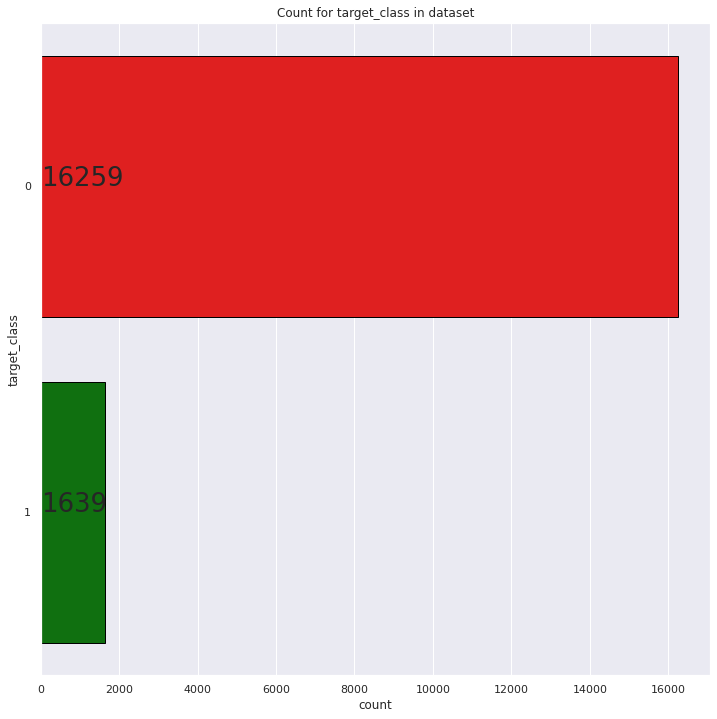

In [ ]:
# First I want to see how many instances of each class we have in the dataset
plt.figure(figsize=(12,12))
ax = sns.countplot(y = data.target_class, palette=["red", "green"],
                  linewidth=1, edgecolor="black")
for i, j in enumerate(data["target_class"].value_counts().values):
    ax.text(.75, i, j, fontsize=26)
plt.title("Count for target_class in dataset");

Only 9% of our target_class are actual pulsars, leaving 91% of the candidate stars in the false-positive category.

### Describing the dataset, visualized through a heatmap

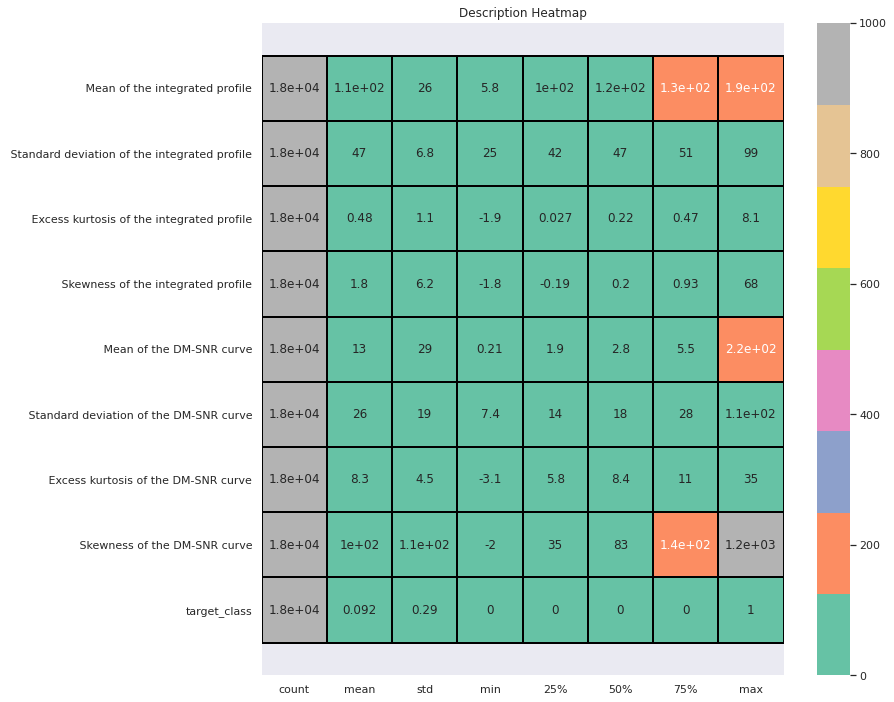

In [ ]:
# I'll use describe() again here but in a visualization to make it a bit easier to understand
plt.figure(figsize=(12,12))
ax = sns.heatmap(data.describe().transpose(),
           annot=True, linecolor="black",
            linewidth=1, square=True, vmin=0, vmax=1000,
                 cmap=sns.color_palette("Set2"))
plt.title("Description Heatmap")
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

# unfortunately due to an issue with the current release of matplotlib, the top
# and bottom rows are cut in half without using the workaround code in lines 7-8

### Correlation & multicollinearity heatmap for the features

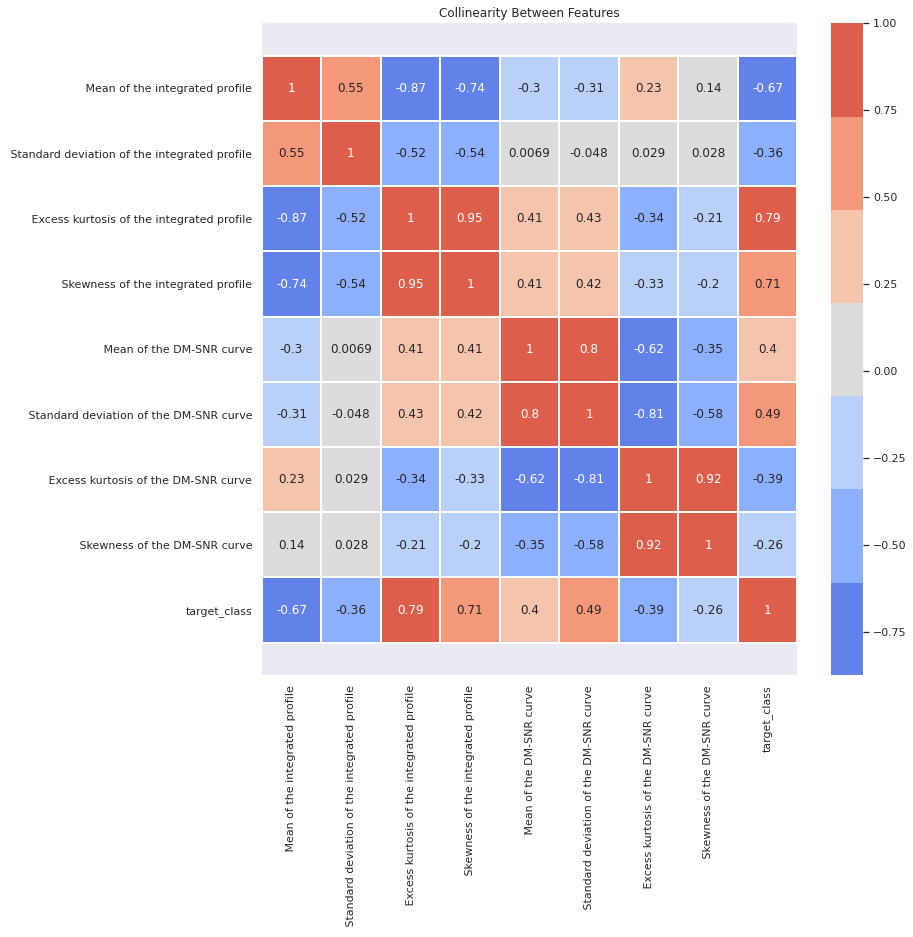

In [ ]:
# Next I'll look at possible multicollinearity among the features
correlation = data.corr()
plt.figure(figsize=(12,12))
ax = sns.heatmap(correlation, annot=True,
                cmap=sns.color_palette("coolwarm", 7),
                linewidth=1, linecolor="white")
plt.title("Collinearity Between Features")
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

In [ ]:
data.columns

Index([' Mean of the integrated profile',
       ' Standard deviation of the integrated profile',
       ' Excess kurtosis of the integrated profile',
       ' Skewness of the integrated profile', ' Mean of the DM-SNR curve',
       ' Standard deviation of the DM-SNR curve',
       ' Excess kurtosis of the DM-SNR curve', ' Skewness of the DM-SNR curve',
       'target_class'],
      dtype='object')

### Comparison of mean and standard deviation between attributes for target_class

Blue = Pulsar, Red = Not a Pulsar


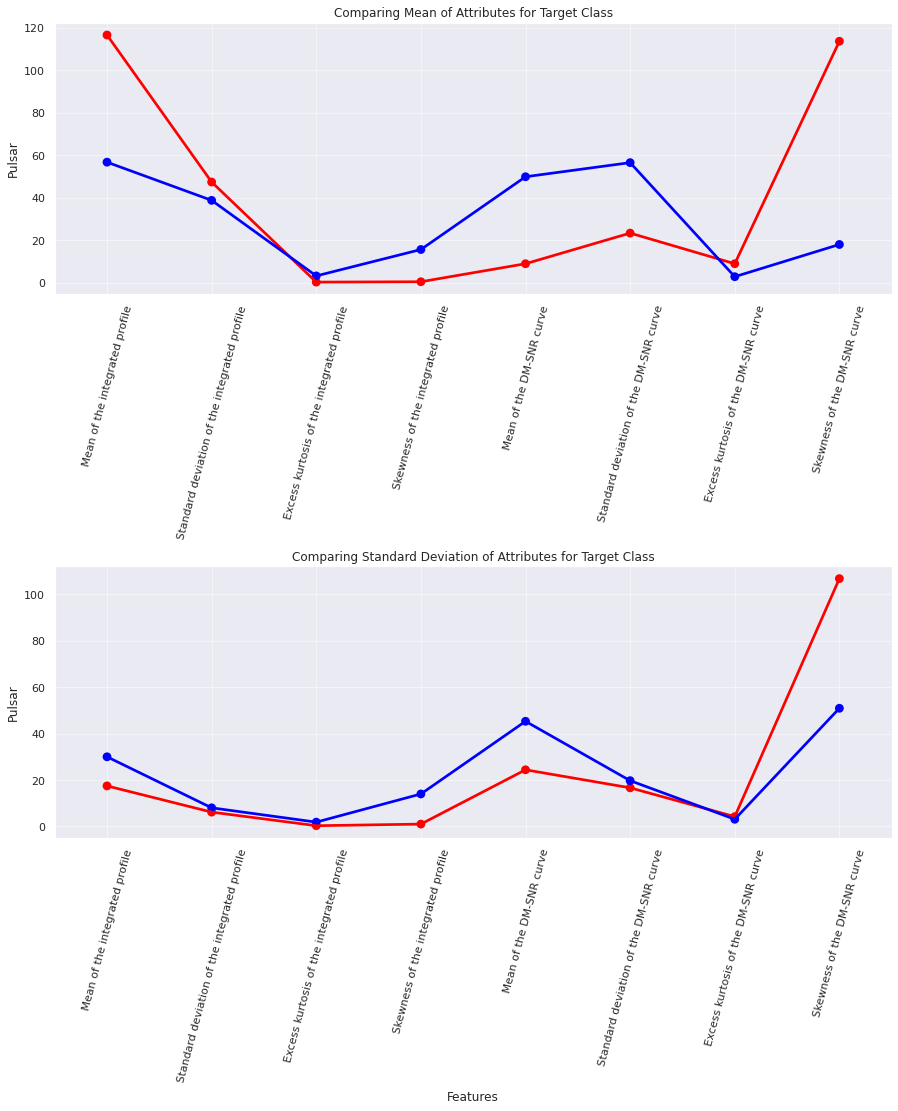

In [ ]:
# Comparison of mean and standard deviation between attributes for target_class
compareMean = data.groupby("target_class")[[' Mean of the integrated profile',
                                            ' Standard deviation of the integrated profile',
                                            ' Excess kurtosis of the integrated profile',
                                            ' Skewness of the integrated profile',
                                            ' Mean of the DM-SNR curve',
                                            ' Standard deviation of the DM-SNR curve',
                                            ' Excess kurtosis of the DM-SNR curve',
                                        ' Skewness of the DM-SNR curve']].mean().reset_index()

compareMean = compareMean.drop("target_class", axis=1)
compareMean = compareMean.transpose().reset_index()
compareMean = compareMean.rename(columns={"index":"Features", 0:"Not a Pulsar", 1:"Pulsar"})

plt.figure(figsize=(15,15))
plt.subplot(211)
sns.pointplot(x="Features", y="Not a Pulsar", data=compareMean, color="red")
sns.pointplot(x="Features", y="Pulsar", data=compareMean, color="blue")
plt.xticks(rotation=75)
plt.xlabel("")
plt.grid(True, alpha=0.5)
plt.title("Comparing Mean of Attributes for Target Class")

compareStd = data.groupby("target_class")[[' Mean of the integrated profile',
                                            ' Standard deviation of the integrated profile',
                                            ' Excess kurtosis of the integrated profile',
                                            ' Skewness of the integrated profile',
                                            ' Mean of the DM-SNR curve',
                                            ' Standard deviation of the DM-SNR curve',
                                            ' Excess kurtosis of the DM-SNR curve',
                                        ' Skewness of the DM-SNR curve']].std().reset_index()

compareStd = compareStd.drop("target_class", axis=1)
compareStd = compareStd.transpose().reset_index()
compareStd = compareStd.rename(columns={'index':"Features", 0:"Not a Pulsar", 1:"Pulsar"})
plt.subplot(212)
sns.pointplot(x="Features", y="Not a Pulsar", data=compareStd, color="red")
sns.pointplot(x="Features", y="Pulsar", data=compareStd, color="blue")
plt.xticks(rotation=75)
plt.grid(True, alpha=0.5)
plt.title("Comparing Standard Deviation of Attributes for Target Class")
plt.subplots_adjust(hspace = 1)
print("Blue = Pulsar, Red = Not a Pulsar")
plt.show();

### Plotted distributions of features within the dataset

Plotting the distributions of features in dataset


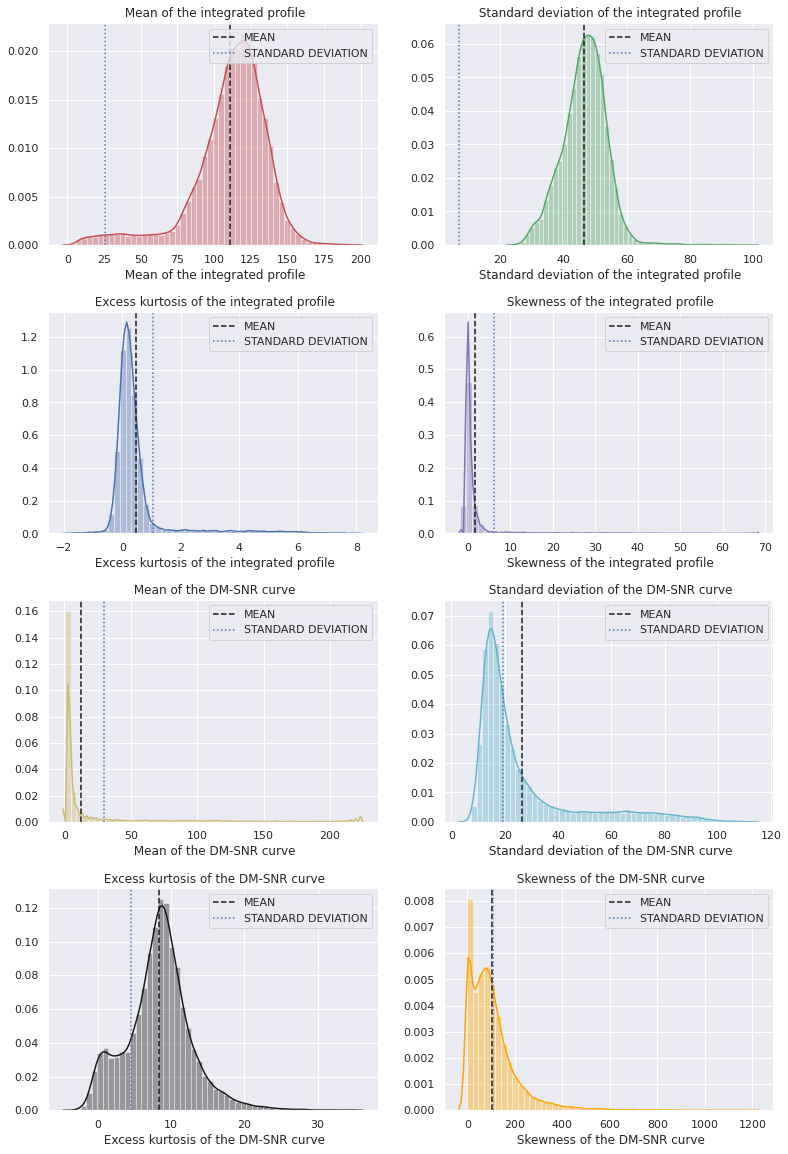

In [ ]:
columns = [' Mean of the integrated profile', ' Standard deviation of the integrated profile',
           ' Excess kurtosis of the integrated profile', ' Skewness of the integrated profile',
            ' Mean of the DM-SNR curve', ' Standard deviation of the DM-SNR curve',
           ' Excess kurtosis of the DM-SNR curve', ' Skewness of the DM-SNR curve']
length  = len(columns)
colors  = ["r","g","b","m","y","c","k","orange"]

plt.figure(figsize=(13,20))
for i,j,k in itertools.zip_longest(columns,range(length),colors):
    plt.subplot(length/2,length/4,j+1)
    sns.distplot(data[i],color=k)
    plt.title(i)
    plt.subplots_adjust(hspace = .3)
    plt.axvline(data[i].mean(),color = "k",linestyle="dashed",label="MEAN")
    plt.axvline(data[i].std(),color = "b",linestyle="dotted",label="STANDARD DEVIATION")
    plt.legend(loc="upper right")

print ("Plotting the distributions of features in dataset")


### Scatter plot showing skewness and kurtosis of the IPP and DM-SNR Curve related to target_class

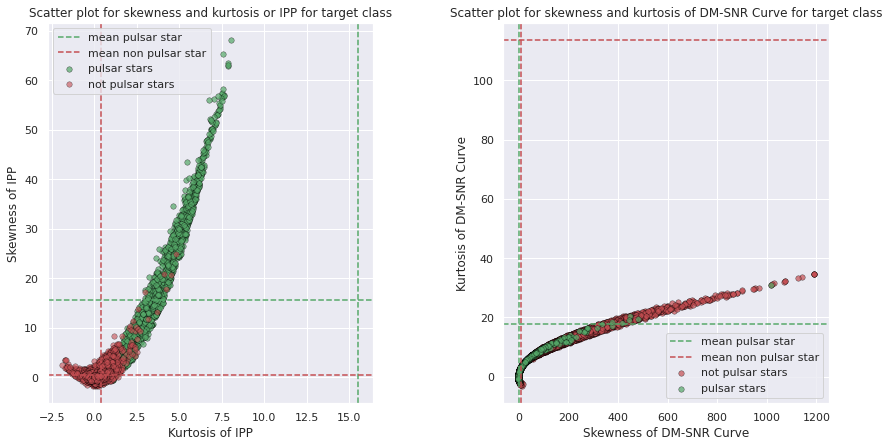

In [ ]:
# Scatter plotting skewness and kurtosis for Integrate Pulse Profile and
# the DM-SNR Curve related to the target_class
plt.figure(figsize=(14,7))
plt.subplot(121)
plt.scatter(x = " Excess kurtosis of the integrated profile",
            y = " Skewness of the integrated profile",
            data=data[data["target_class"] == 1],alpha=.7,
            label="pulsar stars",s=30,color = "g",linewidths=.4,edgecolors="black")
plt.scatter(x = " Excess kurtosis of the integrated profile",
            y = " Skewness of the integrated profile",
            data=data[data["target_class"] == 0],alpha=.6,
            label="not pulsar stars",s=30,color ="r",linewidths=.4,edgecolors="black")
plt.axvline(data[data["target_class"] == 1][" Skewness of the integrated profile"].mean(),
            color = "g",linestyle="dashed",label="mean pulsar star")
plt.axvline(data[data["target_class"] == 0][" Skewness of the integrated profile"].mean(),
            color = "r",linestyle="dashed",label ="mean non pulsar star")
plt.axhline(data[data["target_class"] == 1][" Skewness of the integrated profile"].mean(),
            color = "g",linestyle="dashed")
plt.axhline(data[data["target_class"] == 0][" Skewness of the integrated profile"].mean(),
            color = "r",linestyle="dashed")
plt.legend(loc ="best")
plt.xlabel("Kurtosis of IPP")
plt.ylabel("Skewness of IPP")
plt.title("Scatter plot for skewness and kurtosis or IPP for target class")
plt.subplot(122)
plt.scatter(x = " Skewness of the DM-SNR curve",y = ' Excess kurtosis of the DM-SNR curve',
            data=data[data["target_class"] == 0],alpha=.7,
            label="not pulsar stars",s=30,color ="r",linewidths=.4,edgecolors="black")
plt.scatter(x = " Skewness of the DM-SNR curve",y = ' Excess kurtosis of the DM-SNR curve',
            data=data[data["target_class"] == 1],alpha=.7,
            label="pulsar stars",s=30,color = "g",linewidths=.4,edgecolors="black")
plt.axvline(data[data["target_class"] == 1][" Excess kurtosis of the DM-SNR curve"].mean(),
            color = "g",linestyle="dashed",label ="mean pulsar star")
plt.axvline(data[data["target_class"] == 0][" Excess kurtosis of the DM-SNR curve"].mean(),
            color = "r",linestyle="dashed",label ="mean non pulsar star")
plt.axhline(data[data["target_class"] == 1][" Skewness of the DM-SNR curve"].mean(),
            color = "g",linestyle="dashed")
plt.axhline(data[data["target_class"] == 0][" Skewness of the DM-SNR curve"].mean(),
            color = "r",linestyle="dashed")
plt.legend(loc ="best")
plt.xlabel("Skewness of DM-SNR Curve")
plt.ylabel('Kurtosis of DM-SNR Curve')
plt.title("Scatter plot for skewness and kurtosis of DM-SNR Curve for target class")
plt.subplots_adjust(wspace =.4)

### Boxplots for attributes related to target class


Boxplots for features related to target_class


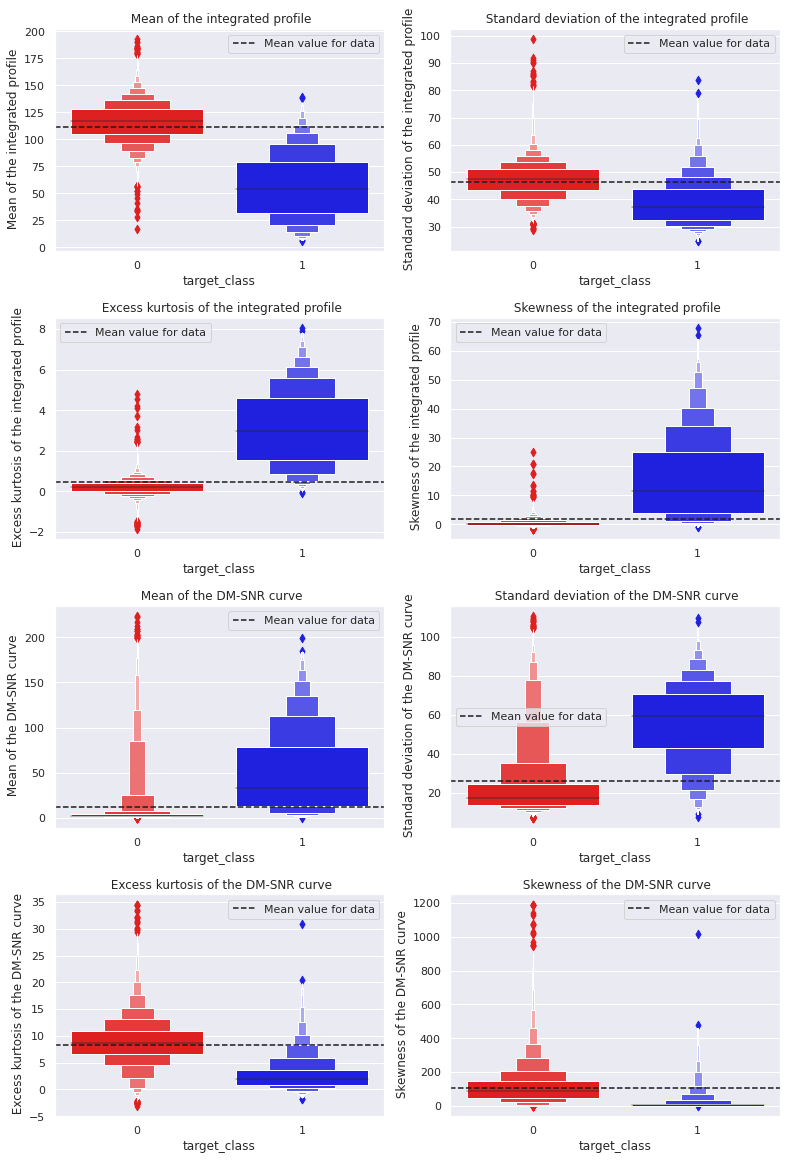

In [ ]:
columns = [x for x in data.columns if x not in ["target_class"]]
length  = len(columns)
plt.figure(figsize=(13,20))
for i,j in itertools.zip_longest(columns,range(length)):
    plt.subplot(4,2,j+1)
    sns.lvplot(x=data["target_class"],y=data[i],palette=["red","blue"])
    plt.title(i)
    plt.subplots_adjust(hspace=.3)
    plt.axhline(data[i].mean(),linestyle = "dashed",color ="k",label ="Mean value for data")
    plt.legend(loc="best")

print ("Boxplots for features related to target_class")

### Histogram normality check and confirmation of absense of categorical features

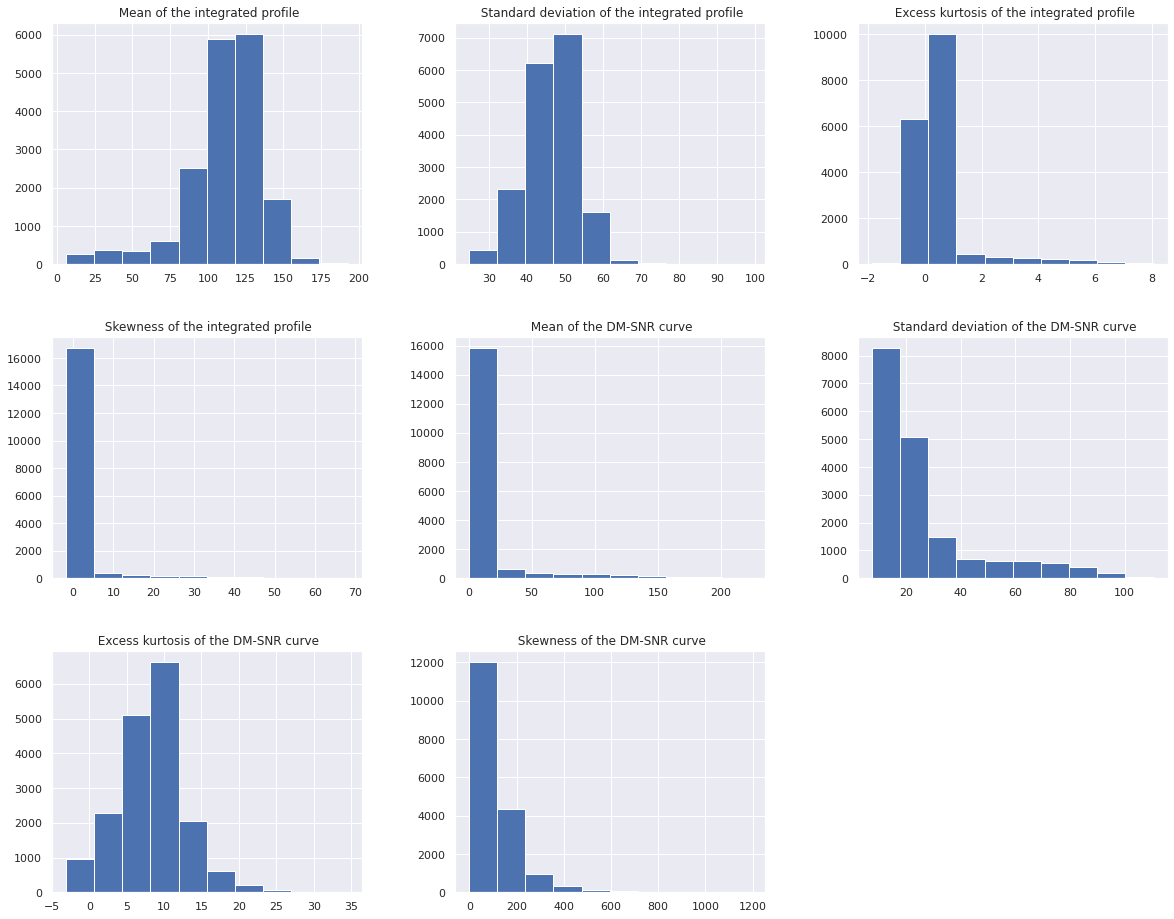

In [ ]:
hist_cols = [' Mean of the integrated profile',
            ' Standard deviation of the integrated profile',
            ' Excess kurtosis of the integrated profile',
            ' Skewness of the integrated profile',
            ' Mean of the DM-SNR curve',
            ' Standard deviation of the DM-SNR curve',
            ' Excess kurtosis of the DM-SNR curve',
            ' Skewness of the DM-SNR curve']

# Define figure size & axis
fig,ax = plt.subplots(figsize = (20,16))

# Plot histograms
data.hist(column=hist_cols,ax=ax);

### EDA Summary
By looking at the target class counts bar chart, we can clearly see there is a
large class imbalance. True positives of our target class instance only make
up 9% of the dataset.

The two features of kurtosis and skewness of the integrated pulse profile are
closely correlated, in the early stages of the modeling section, I may end up removing
one of them. I will reexamine that after doing some baseline modeling and begin
doing feature selection and engineering.   
The mean and standard deviation  of the DM-SNR curve attributes also seem to be
correlated, but again, that will be revisited in the early stages of modeling.
Also, the kurtosis and skewness of the DM-SNR curve also seem to be correlated.
Finally, the kurtosis of the integrated pulse profile seems to be fairly correlated(.79)
with our target_class. I'll continue to test this correlation and see if there is a
true, solid relationship between them.   

By comparing the means between our attributes to the target class, we can see some
possible relationships in the pointplots. It seems that the higher the mean of the
integrated pulse profile and the skewness of the the DM-SNR curve, the less likely
the candidate stars are to be actual pulsars.   
When we look at the standard deviation of the two classes compared to one another,
the higher the skewness of the DM-SNR curve also seems to suggest a higher likelihood
of being a false positive.   

None of the features follow a true normal distribution. Kurtosis and skewness of the IPP
are close to normal, but both are ever so slightly positively skewed.  
As mentioned before, I will model both the raw data and transformed & normalized data
to see if there is an increase in accuracy from normalizing these attributes.   

When we examine the scatterplots that display the relationships between the skewness
and kurtosis of the IPP and DM-SNR curves when related to the target_class, we can
make the following assumptions:   
The higher the kurtosis and skewness of the IPP, the more likely it is that the candidate star is a pulsar.   
The lower kurtosis and skewness of the DM-SNR curve, the more likely it is that the candidate star is a pulsar.   

By looking at the boxplots of the attributes, here are some brief summaries of what is shown:   
- The mean of the IPP appears to be higher for false positives.    
- The standared deviation of the IPP for the false positives appear to be slightly higher and have more upper end outliers.   
- The kurtosis of the IPP seems to be smaller/close to 0 for false positives.   
- The skewness of the IPP again is around 0 for false positives, while for actual pulsars, it is much larger.   
- The mean of the DM-SNR curve is typically higher for actual pulsars, compared to false positives.   
- The standard deviation of the DM-SNR curve is higher for actual pulsars than false positives.  
- The kurtosis of the DM-SNR curve is higher for false positives than for actual pulsars.   
- The skewness of the DM-SNR curve is significantly higher for false positives than for actual pulsars.    

Finally, we can see again in the histograms that there are no normal distributions and
none of our data is categorical.

# Model the Data
In this section I'll dive into the pre-processing related to modeling, normalize the secondary dataset, account for class imbalance, run a baseline model to be improved upon, and use a variety of libraries to create a number of types of models to see what performs best in the context. "Best" is going to be related to the model accuracy, using F1 score(especially for target class) as a metric of success. We'll take a close look at confusion matrices for each model type, and review all types in a conclusion.

### Transformation and Normalization
Below I'll normalize our cloned dataset to be modeled alongside with and compared to our raw dataset.

In [ ]:
# check the preview of the dataset
TNdata.head()

,Mean of the integrated profile,Standard deviation of the integrated profile,Excess kurtosis of the integrated profile,Skewness of the integrated profile,Mean of the DM-SNR curve,Standard deviation of the DM-SNR curve,Excess kurtosis of the DM-SNR curve,Skewness of the DM-SNR curve,target_class
0,140.562500,55.683782,-0.234571,-0.699648,3.199833,19.110426,7.975532,74.242225,0
1,102.507812,58.882430,0.465318,-0.515088,1.677258,14.860146,10.576487,127.393580,0
2,103.015625,39.341649,0.323328,1.051164,3.121237,21.744669,7.735822,63.171909,0
3,136.750000,57.178449,-0.068415,-0.636238,3.642977,20.959280,6.896499,53.593661,0
4,88.726562,40.672225,0.600866,1.123492,1.178930,11.468720,14.269573,252.567306,0


In [ ]:
# use sklearn's preprocessing MinMaxScaler
x = TNdata.values # returns a numpy array
min_max_scaler = MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
TNdata = pd.DataFrame(x_scaled, columns=TNdata.columns)

In [ ]:
TNdata.head()

,Mean of the integrated profile,Standard deviation of the integrated profile,Excess kurtosis of the integrated profile,Skewness of the integrated profile,Mean of the DM-SNR curve,Standard deviation of the DM-SNR curve,Excess kurtosis of the DM-SNR curve,Skewness of the DM-SNR curve,target_class
0,0.721342,0.417687,0.165043,0.015627,0.013382,0.113681,0.294986,0.063890,0.0
1,0.517628,0.460908,0.235415,0.018268,0.006560,0.072524,0.364015,0.108443,0.0
2,0.520346,0.196868,0.221138,0.040677,0.013030,0.139188,0.288624,0.054610,0.0
3,0.700933,0.437884,0.181750,0.016534,0.015368,0.131583,0.266348,0.046581,0.0
4,0.443854,0.214847,0.249044,0.041712,0.004327,0.039684,0.462029,0.213369,0.0


In [ ]:
# confirm the transformation didn't affect our target class
TNdata.target_class.value_counts()

0.0    16259
1.0     1639
Name: target_class, dtype: int64

### Test and Train Splits
Now I'll separate out the target class from the predictor variables and do a train-test split for both sets of data, and account for XGBoost. I've opted to do a 75/25 split.

In [ ]:
# define X and y of our datasets
y_TN = TNdata['target_class']
X_TN = TNdata.drop(['target_class'], axis=1)

y = data['target_class']
X = data.drop(['target_class'], axis=1)

# define random seed
seed = 25

# split data into train and test sets
X_train_TN, X_test_TN, y_train_TN, y_test_TN = train_test_split(X_TN,
                                                    y_TN,
                                                    test_size=0.25,
                                                    random_state=seed)

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.25,
                                                    random_state=seed)

# split in numpy array format for XGBoost
X_train_xgb_TN, X_test_xgb_TN, y_train_xgb_TN, y_test_xgb_TN = train_test_split(X_TN.values,
                                                                    y_TN.values,
                                                                    test_size=0.25,
                                                                    random_state=seed)

X_train_xgb, X_test_xgb, y_train_xgb, y_test_xgb = train_test_split(X.values,
                                                                    y.values,
                                                                    test_size=0.25,
                                                                    random_state=seed)

### Class Imbalance
I'm going to use SMOTE(Synthetic Minority Oversampling TEchnique) to oversample the target class.  
It it important to only use SMOTE on the training data as to not disturb the test set.  

In [ ]:
# Previous original class distribution
print("Before:")
print(f"\n{y_train.value_counts()}")
print(f"\n{pd.Series(y_train_xgb).value_counts()}")

# Fit SMOTE to training data
smote = SMOTE()
X_train_resampled, y_train_resampled = smote.fit_sample(X_train, y_train)
X_train_resampled_TN, y_train_resampled_TN = smote.fit_sample(X_train_TN, y_train_TN)

# format for XGBoost
X_train_resampled_xgb, y_train_resampled_xgb = smote.fit_sample(X_train_xgb, y_train_xgb)
X_train_resampled_xgb_TN, y_train_resampled_xgb_TN = smote.fit_sample(X_train_xgb_TN, y_train_xgb_TN)

# Preview synthetic sample class distribution
print("\nAfter:\n")
print(f"{pd.Series(y_train_resampled).value_counts()}")
print(f"\n{pd.Series(y_train_resampled_xgb).value_counts()}")

Before:

0    12206
1     1217
Name: target_class, dtype: int64

0    12206
1     1217
dtype: int64

After:

1    12206
0    12206
Name: target_class, dtype: int64

1    12206
0    12206
dtype: int64


### Baseline Model
For the baseline model, I'll use the Naive Bayes Classification Algorithm. The Naive Bayes models are very fast and simple algorithms often used for high-dimensional datasets. I'm opting to use this algorithm as a baseline model due to its speed, few tunable parameters, and its reputation as a "quick-and-dirty" baseline for classification problems.   
In order to create a true baseline, I'll only be using the raw dataset for this, and not using the normalized set.  

### Naive Bayes Classification

In [ ]:
aggs = data.groupby('target_class').agg(['mean', 'std'])
aggs

Mean of the integrated profile             \
                                        mean        std   
target_class                                              
0                                 116.562726  17.475932   
1                                  56.690608  30.007707   

              Standard deviation of the integrated profile            \
                                                      mean       std   
target_class                                                           
0                                                47.339741  6.182929   
1                                                38.710598  8.033614   

              Excess kurtosis of the integrated profile            \
                                                   mean       std   
target_class                                                        
0                                              0.210440  0.334606   
1                                              3.130655  1.872861   

              Skewness of the integrated profile             \
                                            mean        std   
target_class                                                  
0                                       0.380844   1.027791   
1                                      15.553576  13.997200   

              Mean of the DM-SNR curve             \
                                  mean        std   
target_class                                        
0                             8.863258  24.411409   
1                            49.825995  45.287932   

              Standard deviation of the DM-SNR curve             \
                                                mean        std   
target_class                                                      
0                                          23.287984  16.651426   
1                                          56.468963  19.731080   

              Excess kurtosis of the DM-SNR curve            \
                                             mean       std   
target_class                                                  
0                                        8.862674  4.238626   
1                                        2.757069  3.105945   

              Skewness of the DM-SNR curve              
                                      mean         std  
target_class                                            
0                               113.620344  106.721930  
1                                17.931728   50.896263

In [ ]:
# calculating conditional probability point estimates
def p_x_given_class(obs_row, feature, class_):
    mu = aggs[feature]['mean'][class_]
    std = aggs[feature]['std'][class_]

    # A single observation
    obs = data.iloc[obs_row][feature]

    p_x_given_y = stats.norm.pdf(obs, loc=mu, scale=std)
    return p_x_given_y

In [ ]:
# testing function with one feature
p_x_given_class(0, ' Mean of the integrated profile', 0)

0.008890734903071604

In [ ]:
# multinomial Bayes using all the features
row = 1
c_probs = []
for c in range(2):
    # Initialize probability to relative probability of class
    p = len(data[data['target_class'] == c])/len(data)
    for feature in X.columns:
        p *= p_x_given_class(row, feature, c)
        # Update the probability using the point estimate for each feature
        c_probs.append(p)

c_probs

[0.01500743162775948,
 0.00016952139267311655,
 0.00015121897097709048,
 4.014278074205181e-05,
 6.282145388588648e-07,
 1.324158136843233e-08,
 1.1484832012705636e-09,
 4.257594410684587e-12,
 0.00037951071487451245,
 8.056777711527314e-07,
 6.234097484933967e-08,
 9.193218960786253e-10,
 4.60200809522998e-12,
 1.007044270716696e-14,
 5.4382186474547034e-17,
 4.219661491818117e-20]

In [ ]:
# calculating class probabilities for obs
def predict_class(row):
    c_probs = []
    for c in range(2):
        # Initialize probability to relative probability of class
        p = len(data[data['target_class'] == c])/len(data)
        for feature in X.columns:
            p *= p_x_given_class(row, feature, c)
        c_probs.append(p)
    return np.argmax(c_probs)

In [ ]:
predict_class(row)

0

In [ ]:
# apply prediction function to the train and test sets
y_hat_train = [predict_class(X_train.iloc[idx]) for idx in range(len(X_train))]
y_hat_test = [predict_class(X_test.iloc[idx]) for idx in range(len(X_test))]

In [ ]:
# calculate training and test accuracy
residuals_train = y_hat_train == y_train
acc_train = residuals_train.sum()/len(residuals_train)

residuals_test = y_hat_test == y_test
acc_test = residuals_test.sum()/len(residuals_test)
print('Training Accuracy: {}\tTesting Accuracy: {}'.format(acc_train, acc_test))

Training Accuracy: 0.19794382775832525	Testing Accuracy: 0.19217877094972066


#### Baseline model summary
As expected, the accuracy of this model is pretty abysmal. It gives us a good starting place to work from and shows how nuanced our dataset is and how dependant on multiple variables the target class is.

### Create Classifiers - Definining Critical Functions
Below I'll define a few functions that will be used in this final modeling phase, instantiate classifiers, run the various models, and then compare the results.  
The models to be run are as follows:  
- Gaussian Naive Bayes
- Decision Tree
- Bagging Tree
- K Nearest Neighbor
- Random Forest
- Logistic Regression
- Extra Tree
- Gradient Boost
- AdaBoost
- XGBoost

#### Important Functions

In [ ]:
# Define function to batch classifiers

def batch_clf(X_train, y_train, X_test, y_test, clf_dict, verbose = True):
    '''
    Fits a dictionary of classifiers, makes predictions, plots ROC, returns metrics

    Args:
        X_train: {array-like, sparse matrix} of shape (n_samples, n_features) train input values
        y_train: array-like of shape (n_samples,) train target values
        X_test: {array-like, sparse matrix} of shape (m_samples, m_features) test input values
        y_test: array-like of shape (m_samples,) test target values
        clf_dict: dictionary with key name of classifier and value classifier instance
        verbose: if True, prints time taken to fit and predict for each classifier

    Returns:
        Results dataframe
    '''
    # Create empty DataFrame to store results
    times = []
    train_acc_scores = []
    test_acc_scores = []
    train_f1_scores = []
    test_f1_scores = []
    train_precision_scores = []
    test_precision_scores = []
    train_recall_scores = []
    test_recall_scores = []
    train_roc_data = []
    test_roc_data = []
    test_profit_scores = []

    # Loop through dictionary items
    for key, clf in clf_dict.items():
        start_time = time.clock()

        # Fit classifier
        clf_fitted = clf.fit(X_train,y_train)

        # Get Predictions
        train_preds = clf_fitted.predict(X_train)
        test_preds = clf_fitted.predict(X_test)


        #Get accuracy scores
        train_acc = accuracy_score(y_train, train_preds)
        train_acc_scores.append(round(train_acc,2))
        test_acc = accuracy_score(y_test, test_preds)
        test_acc_scores.append(round(test_acc,2))

        #Get F1 Scores
        train_f1 = f1_score(y_train, train_preds)
        train_f1_scores.append(round(train_f1,2))
        test_f1 = f1_score(y_test, test_preds)
        test_f1_scores.append(round(test_f1,2))

        # Get Precision Scores
        train_precision = precision_score(y_train, train_preds)
        train_precision_scores.append(round(train_precision,2))
        test_precision = precision_score(y_test, test_preds)
        test_precision_scores.append(round(test_precision,2))

        # Get Recall Scores
        train_recall = recall_score(y_train, train_preds)
        train_recall_scores.append(round(train_recall,2))
        test_recall = recall_score(y_test, test_preds)
        test_recall_scores.append(round(test_recall,2))

        # Get Probability Predictions
        train_hat = clf_fitted.predict_proba(X_train)
        train_proba = train_hat[:,1]
        fpr_train, tpr_train, thresholds_train = roc_curve(y_train, train_proba)
        train_roc_data.append([fpr_train, tpr_train, thresholds_train])

        test_hat = clf_fitted.predict_proba(X_test)
        test_proba = test_hat[:,1]
        fpr_test, tpr_test, thresholds_test = roc_curve(y_test, test_proba)
        test_roc_data.append([fpr_test, tpr_test, thresholds_test])

        # Get Profit

        #best_t, best_profit = profit_threshold_optimizer(y_test, test_proba)
        #test_profit_scores.append(best_profit)

        end_time = time.clock()
        time_elapsed = end_time - start_time
        times.append(round(time_elapsed,2))

        if verbose:
            print(f'trained {key} in {round(time_elapsed,2)}')

    # Create results dataframe
    results = pd.DataFrame({'Model': list(clf_dict.keys()),
                            'Time': times,
                            'Train Accuracy': train_acc_scores,
                            'Test Accuracy': test_acc_scores,
                            'Train F1': train_f1_scores,
                            'Test F1': test_f1_scores,
                            'Train Precision' : train_precision_scores,
                            'Test Precision' : test_precision_scores,
                            'Train Recall': train_recall_scores,
                            'Test Recall': test_recall_scores,
                            'Test Profit' : test_profit_scores
                            })

   # Plot side by side ROC curve
    fig, axes = plt.subplots(1,2, figsize = (13,6))

    for i in range(len(train_roc_data)):
        axes[0].plot(train_roc_data[i][0], train_roc_data[i][1], lw=4, \
                 label= f'{list(clf_dict.keys())[i]}')

    for i in range(len(test_roc_data)):
        axes[1].plot(test_roc_data[i][0], test_roc_data[i][1], lw=4, \
                 label= f'{list(clf_dict.keys())[i]}')

    for ax in axes:
        ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.legend(loc='lower right')
    axes[0].set_title('Receiver operating characteristic (ROC) Curve \n Training Set')
    axes[1].set_title('Receiver operating characteristic (ROC) Curve \n Test Set')
    plt.show()

    return results

In [ ]:
# Define function to fit our models and predict on the training and test sets

def clf_pred(models):
    '''
    Intakes our DataFrame with our models
        and our X & y, train & test data

    Returns a DataFrame with all of our models,
        metrics and accuracy scores
    '''

    # Initialize matrix to fill
    clf_df = np.zeros((len(models), 26), dtype=object)

    for i,model in models.iterrows():


        # Classifier Names & Models
        clf_df[i,0] = model['clf_name']
        clf_df[i,1] = model['clfs']

        ### Assign Variables ###
        # We do this here because XGBoost takes
        # np.array format unlike the other models
        X_train = model['X_train']
        X_test = model['X_test']
        y_train = model['y_train']
        y_test = model['y_test']

        ### Initialize Timer ###
        start_time = time.time()

        ### Fit & Predict ###

        # Fit Model
        fitted = model['clfs'].fit(X_train, y_train)
        clf_df[i,2] = fitted

        # Calculate time to fit model
        stop_time = time.time()
        runtime = (stop_time - start_time)
        clf_df[i,3] = runtime

        # Predict
        y_pred_train = fitted.predict(X_train)
        y_pred_test = fitted.predict(X_test)

        clf_df[i,4] = y_pred_train
        clf_df[i,5] = y_pred_test

        # y_score
        y_score_train = fitted.predict_proba(X_train)
        y_score_test = fitted.predict_proba(X_test)
        clf_df[i,6] = y_score_train
        clf_df[i,7] = y_score_test

        # False & True Positive Rates
        clf_df[i,8], clf_df[i,9], thresholds_train = roc_curve(y_train, y_score_train[:,1])
        clf_df[i,10], clf_df[i,11], thresholds_test = roc_curve(y_test, y_score_test[:,1])


        ### Accuracy Scores ###

        # Precision
        clf_df[i,12] = precision_score(y_train, y_pred_train)
        clf_df[i,13] = precision_score(y_test, y_pred_test)

        # Recall
        clf_df[i,14] = recall_score(y_train, y_pred_train)
        clf_df[i,15] = recall_score(y_test, y_pred_test)

        # F1
        clf_df[i,16] = f1_score(y_train, y_pred_train)
        clf_df[i,17] = f1_score(y_test, y_pred_test)

        # Accuracy
        clf_df[i,18] = accuracy_score(y_train, y_pred_train)
        clf_df[i,19] = accuracy_score(y_test, y_pred_test)

        # AUC
        clf_df[i,20] = roc_auc_score(y_train, y_pred_train)
        clf_df[i,21] = roc_auc_score(y_test, y_pred_test)

        ### Add X & y values to have everything in one place ###
        # These are class balanced/resampled #
        clf_df[i,22] = X_train
        clf_df[i,23] = X_test
        clf_df[i,24] = y_train
        clf_df[i,25] = y_test

    ### Create DataFrame ###

    # Column Names
    columns = ['Classifier',
               'Model',
               'Fitted Model',
               'Runtime',
               'Train Preds',
               'Test Preds',
               'Train y-Score',
               'Test y-Score',
               'Train FPR',
               'Train TPR',
               'Test FPR',
               'Test TPR',
               'Train Precision',
               'Test Precision',
               'Train Recall',
               'Test Recall',
               'Train F1',
               'Test F1',
               'Train Accuracy',
               'Test Accuracy',
               'Train ROC AUC',
               'Test ROC AUC',
               'X_train',
               'X_test',
               'y_train',
               'y_test'
              ]

    # Create DataFrame
    clf_df = pd.DataFrame(clf_df, columns=columns)

    return clf_df

In [ ]:
# Function to combine classification report, confusion matrix,
# accuracy score, roc curve, and auc in one easy way

def model(algorithm, X_train, y_train, X_test, y_test, of_type):
    algorithm.fit(X_train, y_train)
    preds = algorithm.predict(X_test)

    print(algorithm)
    print("\naccuracy_score:",accuracy_score(y_test, preds))
    print("\nclassification report:\n", (classification_report(y_test, preds)))

    plt.figure(figsize=(14,10))
    plt.subplot(221)
    ax = sns.heatmap(confusion_matrix(y_test, preds), annot=True, fmt="d",
                linecolor="k", linewidth=2)
    # work around for top & bottom cutoff is pasted below
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    plt.title("Confusion Matrix", fontsize=20)

    predicting_probabilities = algorithm.predict_proba(X_test)[:,1]
    fpr, tpr, thresholds = roc_curve(y_test, predicting_probabilities)
    plt.subplot(222)
    plt.plot(fpr, tpr, label = ("Area Under the Curve:", auc(fpr, tpr)), color="r")
    plt.plot([1,0], [1,0], linestyle = "dashed", color="k")
    plt.legend(loc="best")
    plt.title("ROC Curve and Area Under Curve", fontsize=20)

    if of_type == "feat":
        dataframe = pd.DataFrame(algorithm.feature_importances_, X_train.columns).reset_index()
        dataframe = dataframe.rename(columns={"index":"features", 0:"coefficients"})
        dataframe = dataframe.sort_values(by="coefficients", ascending=False)
        # plot conf_matrix, roc/auc, and feat importances
        plt.subplot(223)
        ax = sns.barplot(x = "coefficients", y = "features", data = dataframe, palette = "husl")
        plt.title("Feature Importances", fontsize=20)
        for i, j in enumerate(dataframe["coefficients"]):
            ax.text(.011, i, j, weight = "bold")

    elif of_type == "coef":
        dataframe = pd.DataFrame(algorithm.coef_.ravel(), X_train.columns).reset_index()
        dataframe = dataframe.rename(columns={"index":"features", 0:"coefficients"})
        dataframe = dataframe.sort_values(by="coefficients", ascending=False)
        # plot conf_matrix, roc/auc, and feat importances
        plt.subplot(223)
        ax = sns.barplot(x = "coefficients", y = "features", data = dataframe, palette = "husl")
        plt.title("Feature Importances", fontsize=20)
        for i, j in enumerate(dataframe["coefficients"]):
            ax.text(.011, i, j, weight = "bold")

    elif of_type == "none":
        return(algorithm)

#### Create Classifiers

In [ ]:
# Gaussian Naive Bayes
gnb = GaussianNB() # none

# Decision Tree
dt = DecisionTreeClassifier() # feat

# Bagging Tree
bag = BaggingClassifier(base_estimator=DecisionTreeClassifier(),
                        random_state=seed) # feat

# K Nearest Neighbor
knn = KNeighborsClassifier() # none

# Random Forest
rf = RandomForestClassifier() # feat

# Logistic Regression
log = LogisticRegression() # coef

# Extra Tree
ext = ExtraTreeClassifier()  # feat

# Gradient Boost
gb = GradientBoostingClassifier() # feat

# AdaBoost
adb = AdaBoostClassifier() # feat

# XGBoost
xgb = xgb.XGBClassifier(random_state=seed)

# Create dictionary of classifiers for raw data
clf_dict = {0:
    {'clf_name': 'Gaussian Naive Bayes',
     'clfs': gnb,
     'X_train': X_train_resampled,
     'X_test': X_test,
     'y_train': y_train_resampled,
     'y_test': y_test},
            1:
    {'clf_name': 'Decision Tree',
     'clfs': dt,
     'X_train': X_train_resampled,
     'X_test': X_test,
     'y_train': y_train_resampled,
     'y_test': y_test},
            2:
    {'clf_name': 'Bagging Tree',
     'clfs': bag,
     'X_train': X_train_resampled,
     'X_test': X_test_xgb,
     'y_train': y_train_resampled,
     'y_test': y_test_xgb},
            3:
    {'clf_name': 'K Nearest Neighbor',
     'clfs': knn,
     'X_train': X_train_resampled,
     'X_test': X_test,
     'y_train': y_train_resampled,
     'y_test': y_test},
           4:
    {'clf_name': 'Random Forest',
     'clfs': rf,
     'X_train': X_train_resampled,
     'X_test': X_test,
     'y_train': y_train_resampled,
     'y_test': y_test},
           5:
    {'clf_name': 'Logistic Regression',
     'clfs': log,
     'X_train': X_train_resampled,
     'X_test': X_test,
     'y_train': y_train_resampled,
     'y_test': y_test},
           6:
    {'clf_name': 'Extra Tree',
     'clfs': ext,
     'X_train': X_train_resampled,
     'X_test': X_test,
     'y_train': y_train_resampled,
     'y_test': y_test},
           7:
    {'clf_name': 'Gradient Boost',
     'clfs': gb,
     'X_train': X_train_resampled,
     'X_test': X_test,
     'y_train': y_train_resampled,
     'y_test': y_test},
           8:
    {'clf_name': 'AdaBoost',
     'clfs': adb,
     'X_train': X_train_resampled,
     'X_test': X_test,
     'y_train': y_train_resampled,
     'y_test': y_test},
           9:
    {'clf_name': 'XGBoost',
     'clfs': xgb,
     'X_train': X_train_resampled_xgb,
     'X_test': X_test_xgb,
     'y_train': y_train_resampled_xgb,
     'y_test': y_test_xgb}}

# Convert into DataFrame

models_df = pd.DataFrame.from_dict(clf_dict, orient='index')

# Create dictionary of classifiers for normalized data
clf_dict_TN = {0:
    {'clf_name': 'Gaussian Naive Bayes',
     'clfs': gnb,
     'X_train': X_train_resampled_TN,
     'X_test': X_test,
     'y_train': y_train_resampled_TN,
     'y_test': y_test},
            1:
    {'clf_name': 'Decision Tree',
     'clfs': dt,
     'X_train': X_train_resampled_TN,
     'X_test': X_test,
     'y_train': y_train_resampled_TN,
     'y_test': y_test},
            2:
    {'clf_name': 'Bagging Tree',
     'clfs': bag,
     'X_train': X_train_resampled_TN,
     'X_test': X_test_xgb,
     'y_train': y_train_resampled_TN,
     'y_test': y_test_xgb},
            3:
    {'clf_name': 'K Nearest Neighbor',
     'clfs': knn,
     'X_train': X_train_resampled_TN,
     'X_test': X_test,
     'y_train': y_train_resampled_TN,
     'y_test': y_test},
           4:
    {'clf_name': 'Random Forest',
     'clfs': rf,
     'X_train': X_train_resampled_TN,
     'X_test': X_test,
     'y_train': y_train_resampled_TN,
     'y_test': y_test},
           5:
    {'clf_name': 'Logistic Regression',
     'clfs': log,
     'X_train': X_train_resampled_TN,
     'X_test': X_test,
     'y_train': y_train_resampled_TN,
     'y_test': y_test},
           6:
    {'clf_name': 'Extra Tree',
     'clfs': ext,
     'X_train': X_train_resampled_TN,
     'X_test': X_test,
     'y_train': y_train_resampled_TN,
     'y_test': y_test},
           7:
    {'clf_name': 'Gradient Boost',
     'clfs': gb,
     'X_train': X_train_resampled_TN,
     'X_test': X_test,
     'y_train': y_train_resampled_TN,
     'y_test': y_test},
           8:
    {'clf_name': 'AdaBoost',
     'clfs': adb,
     'X_train': X_train_resampled_TN,
     'X_test': X_test,
     'y_train': y_train_resampled_TN,
     'y_test': y_test},
           9:
    {'clf_name': 'XGBoost',
     'clfs': xgb,
     'X_train': X_train_resampled_xgb_TN,
     'X_test': X_test,
     'y_train': y_train_resampled_xgb_TN,
     'y_test': y_test}}

# Convert into DataFrame

models_df_TN = pd.DataFrame.from_dict(clf_dict_TN, orient='index')

### Fit and Predict
I'll use the above classifier predictions function to run through both dictionaries of Classifiers. The function organizes the results on a table for easy comparison.

#### Prediction on raw data

In [ ]:
clf_preds = clf_pred(models_df)
clf_preds

,Classifier,Model,Fitted Model,Runtime,Train Preds,Test Preds,Train y-Score,Test y-Score,Train FPR,Train TPR,...,Train F1,Test F1,Train Accuracy,Test Accuracy,Train ROC AUC,Test ROC AUC,X_train,X_test,y_train,y_test
0,Gaussian Naive Bayes,GaussianNB(),GaussianNB(),0.00913024,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[1.0, 5.231338689844232e-23], [0.999999908709...","[[0.9999977878044559, 2.212195542300258e-06], ...","[0.0, 0.0016385384237260364, 0.001638538423726...","[0.0, 0.6605767655251515, 0.6636080616090447, ...",...,0.901474,0.735113,0.905292,0.942346,0.905292,0.900238,Mean of the integrated profile \ 0 ...,Mean of the integrated profile \ 3903...,0 0 1 0 2 0 3 0 4 ...,3903 0 7263 0 16215 0 12661 0 14...
1,Decision Tree,DecisionTreeClassifier(),DecisionTreeClassifier(),0.312454,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0...","[[1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0...","[0.0, 0.0, 1.0]","[0.0, 1.0, 1.0]",...,1,0.760125,1,0.94838,1,0.91206,Mean of the integrated profile \ 0 ...,Mean of the integrated profile \ 3903...,0 0 1 0 2 0 3 0 4 ...,3903 0 7263 0 16215 0 12661 0 14...
2,Bagging Tree,(DecisionTreeClassifier(random_state=162809817...,(DecisionTreeClassifier(random_state=162809817...,1.85709,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0...","[[0.8, 0.2], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0...","[0.0, 0.0, 0.0, 0.0, 0.00032770768474520726, 0...","[0.0, 0.92290676716369, 0.963870227756841, 0.9...",...,0.99832,0.848347,0.99832,0.970279,0.99832,0.930519,Mean of the integrated profile \ 0 ...,"[[111.2109375, 38.62998599, 0.212744228, 1.297...",0 0 1 0 2 0 3 0 4 ...,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,K Nearest Neighbor,KNeighborsClassifier(),KNeighborsClassifier(),0.0332222,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0...","[[0.6, 0.4], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0...","[0.0, 0.0, 0.020891364902506964, 0.04473209896...","[0.0, 0.942733082090775, 0.9708340160576766, 0...",...,0.970617,0.704171,0.970179,0.931844,0.970179,0.899747,Mean of the integrated profile \ 0 ...,Mean of the integrated profile \ 3903...,0 0 1 0 2 0 3 0 4 ...,3903 0 7263 0 16215 0 12661 0 14...
4,Random Forest,"(DecisionTreeClassifier(max_features='auto', r...","(DecisionTreeClassifier(max_features='auto', r...",5.46709,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[0.97, 0.03], [1.0, 0.0], [0.99, 0.01], [1.0,...","[[0.86, 0.14], [1.0, 0.0], [1.0, 0.0], [0.96, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.7836310011469769, 0.8547435687366869, ...",...,1,0.866434,1,0.974302,1,0.933801,Mean of the integrated profile \ 0 ...,Mean of the integrated profile \ 3903...,0 0 1 0 2 0 3 0 4 ...,3903 0 7263 0 16215 0 12661 0 14...
5,Logistic Regression,LogisticRegression(),LogisticRegression(),0.299368,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[0.9738774952810246, 0.026122504718975353], [...","[[0.9705200299510388, 0.02947997004896124], [0...","[0.0, 0.0, 0.0, 8.192692118630181e-05, 8.19269...","[0.0, 8.192692118630181e-05, 0.003277076847452...",...,0.945099,0.811688,0.946379,0.961117,0.946379,0.928645,Mean of the integrated profile \ 0 ...,Mean of the integrated profile \ 3903...,0 0 1 0 2 0 3 0 4 ...,3903 0 7263 0 16215 0 12661 0 14...
6,Extra Tree,ExtraTreeClassifier(),ExtraTreeClassifier(),0.019419,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0...","[[1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [0.0, 1.0...","[0.0, 0.0, 1.

### Gaussian Naive Bayes

GaussianNB()

accuracy_score: 0.9486033519553073

classification report:
               precision    recall  f1-score   support

           0       0.98      0.96      0.97      4053
           1       0.69      0.84      0.75       422

    accuracy                           0.95      4475
   macro avg       0.83      0.90      0.86      4475
weighted avg       0.95      0.95      0.95      4475



GaussianNB()

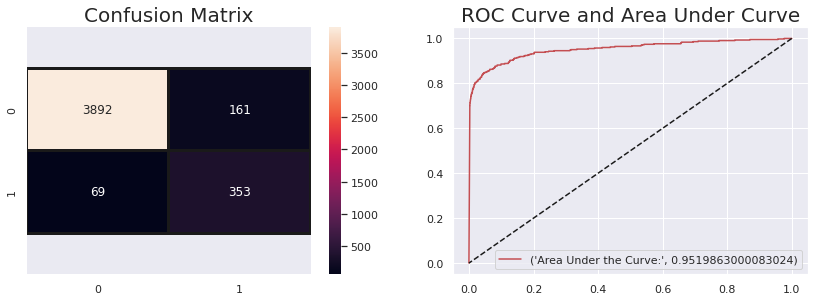

In [ ]:
# raw data
model(gnb, X_train, y_train, X_test, y_test, "none")

GaussianNB()

accuracy_score: 0.7387709497206704

classification report:
               precision    recall  f1-score   support

           0       0.99      0.72      0.83      4053
           1       0.25      0.91      0.40       422

    accuracy                           0.74      4475
   macro avg       0.62      0.82      0.61      4475
weighted avg       0.92      0.74      0.79      4475



GaussianNB()

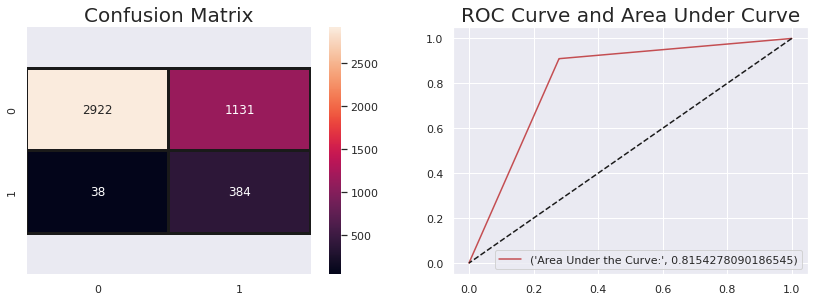

In [ ]:
# normalized data
model(gnb, X_train_TN, y_train_TN, X_test, y_test, "none")

The non-normalized data vastly outperformed the normalized data in the Gaussian Naive Bayes model with an accuracy score of 95 vs 74.  
A target F1 score of .75, this model performed moderately overall. An AUC of .95 indicates decent performance.

### Decision Tree

DecisionTreeClassifier()

accuracy_score: 0.9662569832402235

classification report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98      4053
           1       0.82      0.82      0.82       422

    accuracy                           0.97      4475
   macro avg       0.90      0.90      0.90      4475
weighted avg       0.97      0.97      0.97      4475



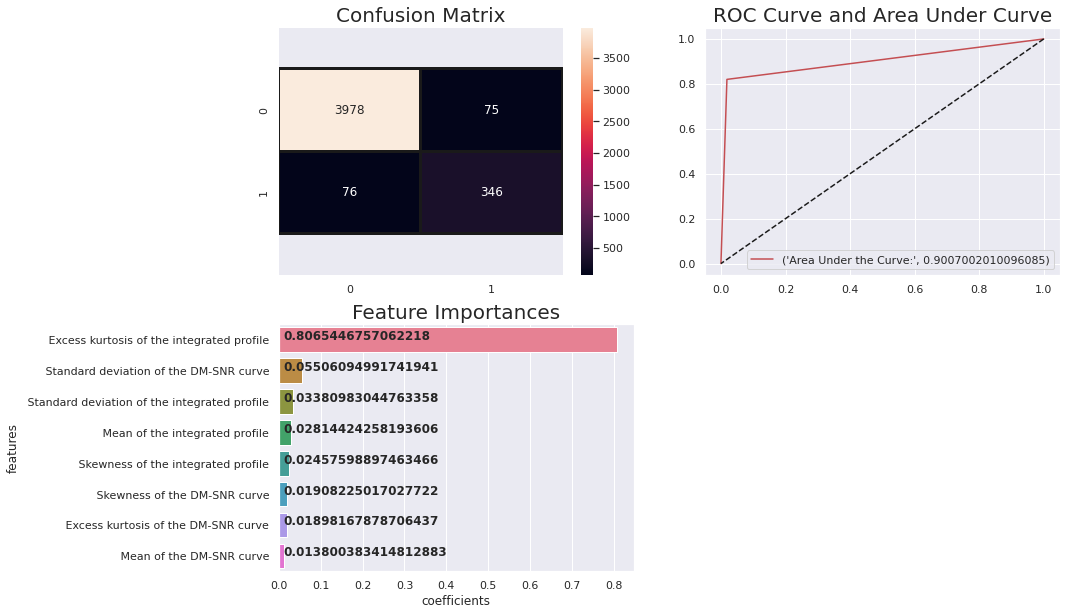

In [ ]:
# raw data
model(dt, X_train, y_train, X_test, y_test, "feat")

DecisionTreeClassifier()

accuracy_score: 0.8127374301675978

classification report:
               precision    recall  f1-score   support

           0       0.99      0.80      0.89      4053
           1       0.33      0.93      0.48       422

    accuracy                           0.81      4475
   macro avg       0.66      0.87      0.68      4475
weighted avg       0.93      0.81      0.85      4475



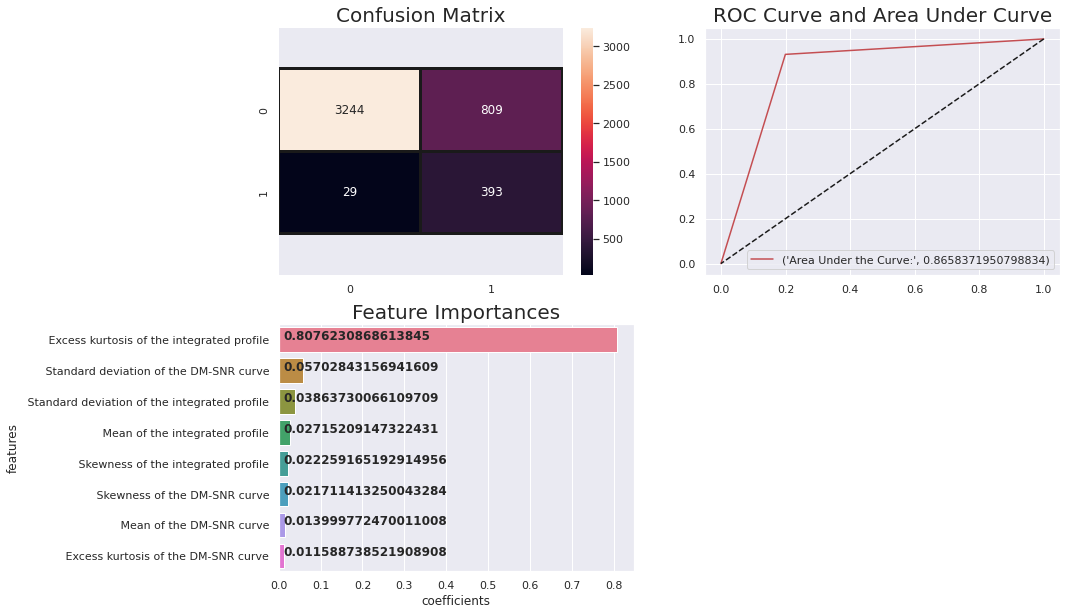

In [ ]:
# normalized data
model(dt, X_train_TN, y_train_TN, X_test, y_test, "feat")

Again, the normalized data performed horribly - a .12 F1 score for the target class.    
However, for our raw data the model performed well. With an overall accuracy of .97 and a target class F1 of .82, it performed better than out Gaussian Naive Bayes model. The AUC of .90 indicates the model performed well.   
We can see that the overwhelmingly most important feature is the Kurtosis of the Integrated Pulse Profile.  
There were far fewer false positives and a similar level of false negatives as the GNB.

### Bagging Tree

BaggingClassifier(base_estimator=DecisionTreeClassifier(), random_state=25)

accuracy_score: 0.9776536312849162

classification report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.99      4053
           1       0.92      0.83      0.88       422

    accuracy                           0.98      4475
   macro avg       0.95      0.91      0.93      4475
weighted avg       0.98      0.98      0.98      4475



BaggingClassifier(base_estimator=DecisionTreeClassifier(), random_state=25)

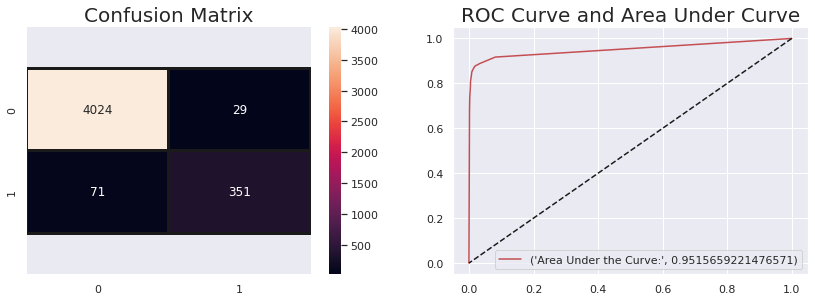

In [ ]:
# raw data
model(bag, X_train, y_train, X_test, y_test, "none")

BaggingClassifier(base_estimator=DecisionTreeClassifier(), random_state=25)

accuracy_score: 0.8205586592178771

classification report:
               precision    recall  f1-score   support

           0       0.90      0.90      0.90      4053
           1       0.02      0.01      0.01       422

    accuracy                           0.82      4475
   macro avg       0.46      0.46      0.46      4475
weighted avg       0.81      0.82      0.82      4475



BaggingClassifier(base_estimator=DecisionTreeClassifier(), random_state=25)

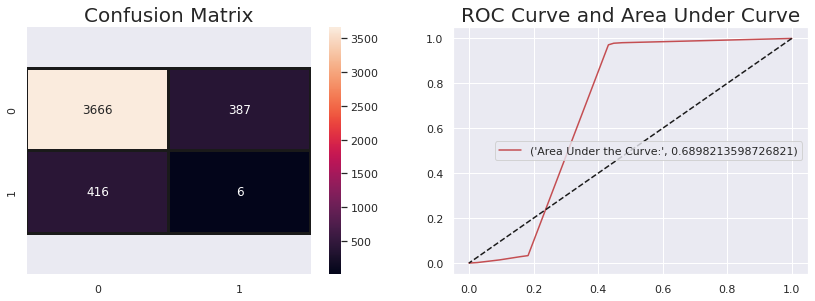

In [ ]:
# normalized data
model(bag, X_train_TN, y_train_TN, X_test, y_test, "none")

This seems to be becoming a trend...The normalized data performed terribly - a .01 F1 score for the target class.    
Our raw data the model performed well. An overall accuracy of .98 and a target class F1 of .88 is good, with very few false positives and less false negatives than GNB or Decision Tree models. The high AUC of .95 supports that.

### K Nearest Neighbor

KNeighborsClassifier()

accuracy_score: 0.9734078212290502

classification report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.99      4053
           1       0.90      0.81      0.85       422

    accuracy                           0.97      4475
   macro avg       0.94      0.90      0.92      4475
weighted avg       0.97      0.97      0.97      4475



KNeighborsClassifier()

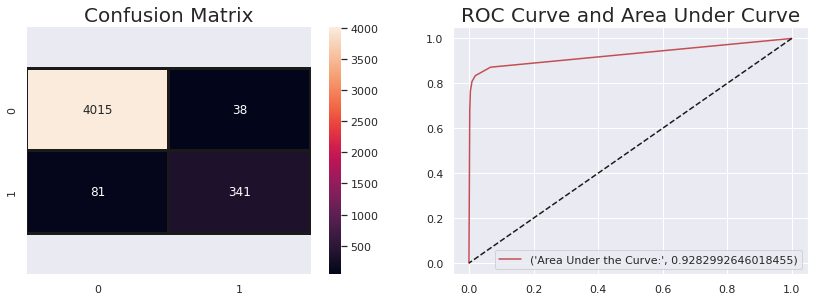

In [ ]:
# raw data
model(knn, X_train, y_train, X_test, y_test, "none")

KNeighborsClassifier()

accuracy_score: 0.9081564245810055

classification report:
               precision    recall  f1-score   support

           0       0.91      1.00      0.95      4053
           1       1.00      0.03      0.05       422

    accuracy                           0.91      4475
   macro avg       0.95      0.51      0.50      4475
weighted avg       0.92      0.91      0.87      4475



KNeighborsClassifier()

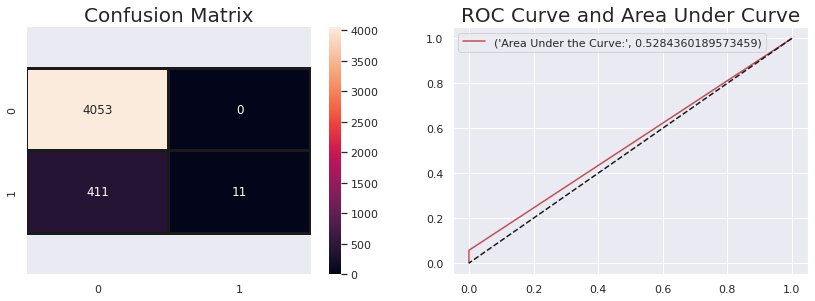

In [ ]:
# normalized data
model(knn, X_train_TN, y_train_TN, X_test, y_test, "none")

Again, normalized model can be ignored.  
An overall accuracy of .97 and a target F1 score of .85 is good, supported by the low number of false positives and comparable(to GNB, Dec Tree, Bagging Tree) false negatives and high AUC of .93.

### Random Forest

RandomForestClassifier()

accuracy_score: 0.9776536312849162

classification report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.99      4053
           1       0.93      0.83      0.87       422

    accuracy                           0.98      4475
   macro avg       0.95      0.91      0.93      4475
weighted avg       0.98      0.98      0.98      4475



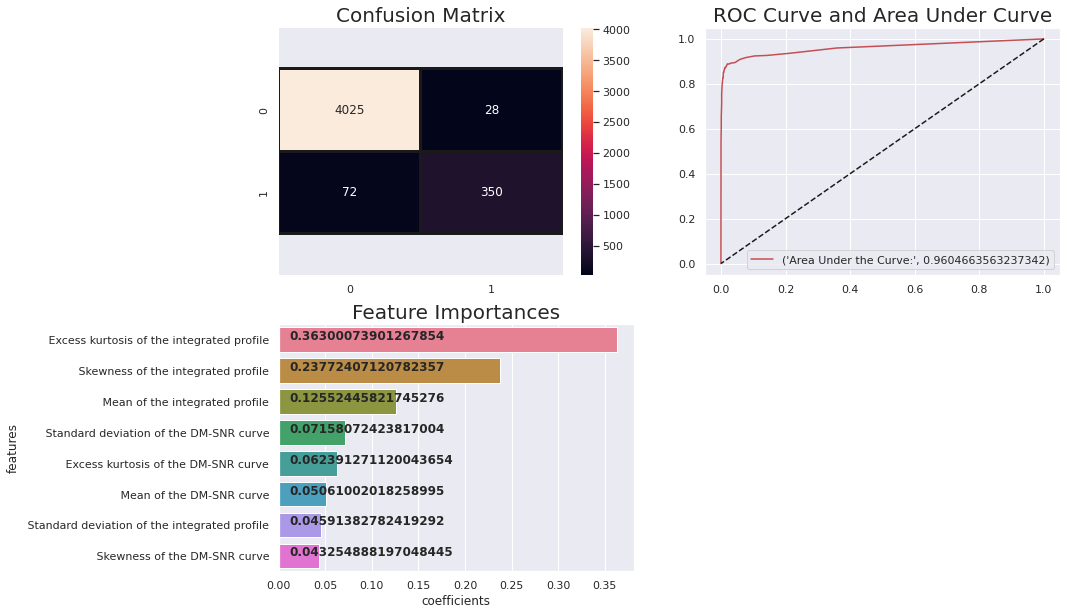

In [ ]:
# raw data
model(rf, X_train, y_train, X_test, y_test, "feat")

RandomForestClassifier()

accuracy_score: 0.6625698324022347

classification report:
               precision    recall  f1-score   support

           0       0.98      0.64      0.78      4053
           1       0.20      0.85      0.32       422

    accuracy                           0.66      4475
   macro avg       0.59      0.75      0.55      4475
weighted avg       0.90      0.66      0.73      4475



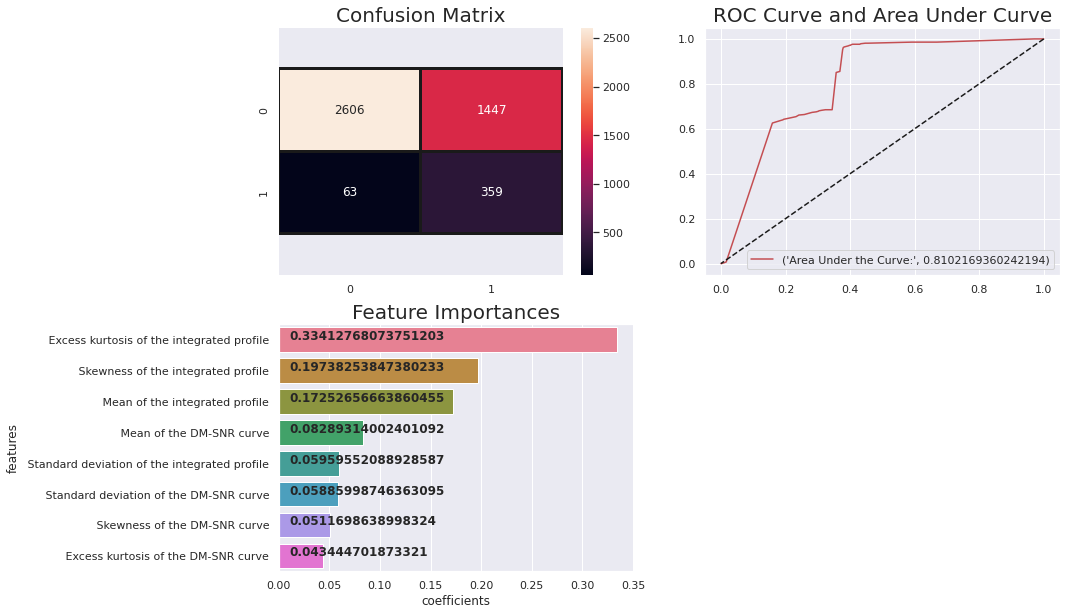

In [ ]:
# normalized data
model(rf, X_train_TN, y_train_TN, X_test, y_test, "feat")

With an accuracy score of .98, a target class F1 score of .87, only 30 false positives, 73 false negatives, and an AUC of .96 this model is our best performing so far. As you can see by looking at the feature importance graph, it seems to take the most amount of features into account which makes me feel a bit more confident in this algorithm and its ability to deal with this type of dataset.

### Logistic Regression

LogisticRegression()

accuracy_score: 0.9772067039106145

classification report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.99      4053
           1       0.93      0.82      0.87       422

    accuracy                           0.98      4475
   macro avg       0.95      0.91      0.93      4475
weighted avg       0.98      0.98      0.98      4475



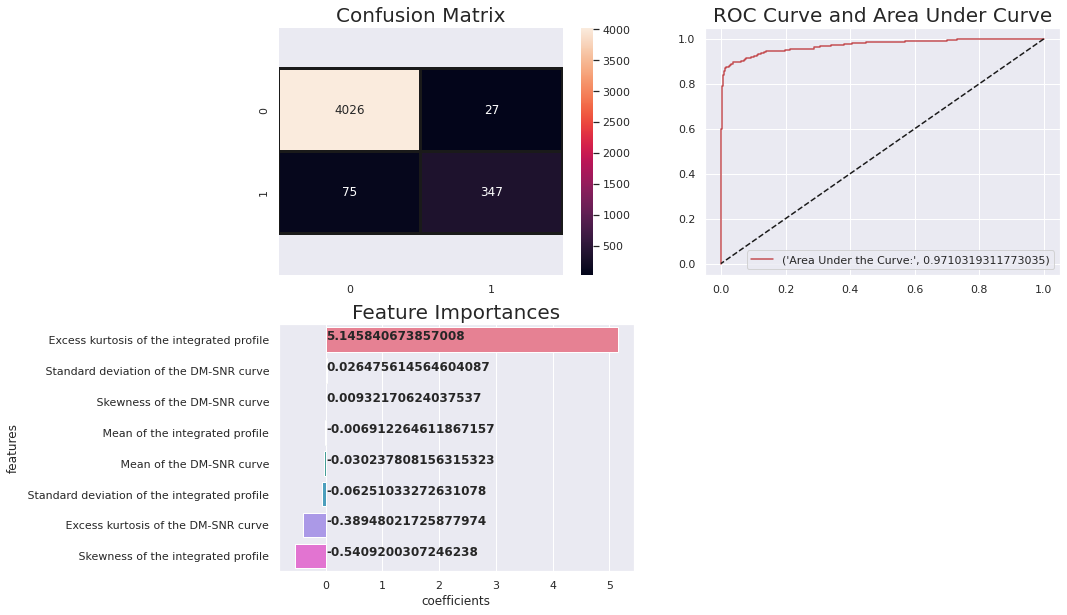

In [ ]:
# raw data
model(log, X_train, y_train, X_test, y_test, "coef")

LogisticRegression()

accuracy_score: 0.9298324022346369

classification report:
               precision    recall  f1-score   support

           0       0.93      1.00      0.96      4053
           1       1.00      0.26      0.41       422

    accuracy                           0.93      4475
   macro avg       0.96      0.63      0.69      4475
weighted avg       0.93      0.93      0.91      4475



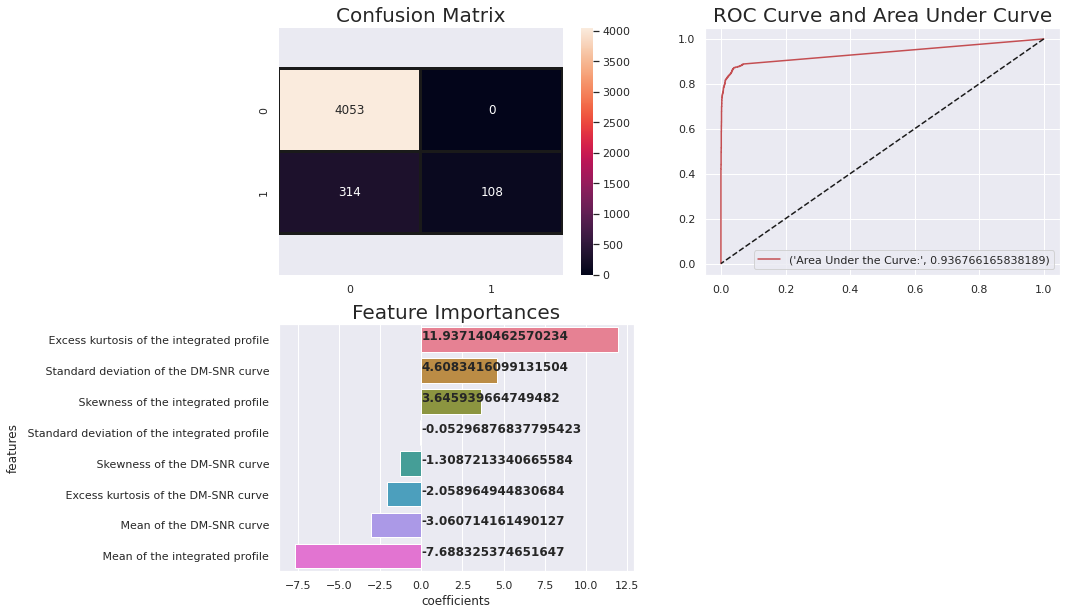

In [ ]:
# normalized data
model(log, X_train_TN, y_train_TN, X_test, y_test, "coef")

This model performed very similarly to our Random Forest model in most metrics.

### Extra Tree

ExtraTreeClassifier()

accuracy_score: 0.9615642458100558

classification report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98      4053
           1       0.80      0.80      0.80       422

    accuracy                           0.96      4475
   macro avg       0.89      0.89      0.89      4475
weighted avg       0.96      0.96      0.96      4475



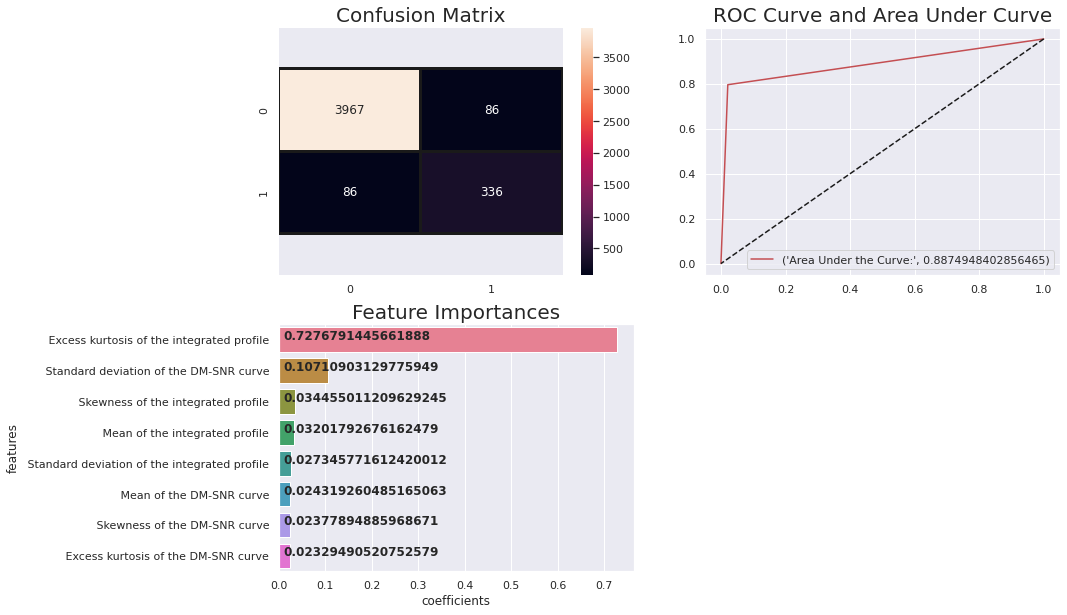

In [ ]:
# raw data
model(ext, X_train, y_train, X_test, y_test, "feat")

ExtraTreeClassifier()

accuracy_score: 0.6011173184357542

classification report:
               precision    recall  f1-score   support

           0       0.99      0.56      0.72      4053
           1       0.19      0.97      0.31       422

    accuracy                           0.60      4475
   macro avg       0.59      0.76      0.52      4475
weighted avg       0.92      0.60      0.68      4475



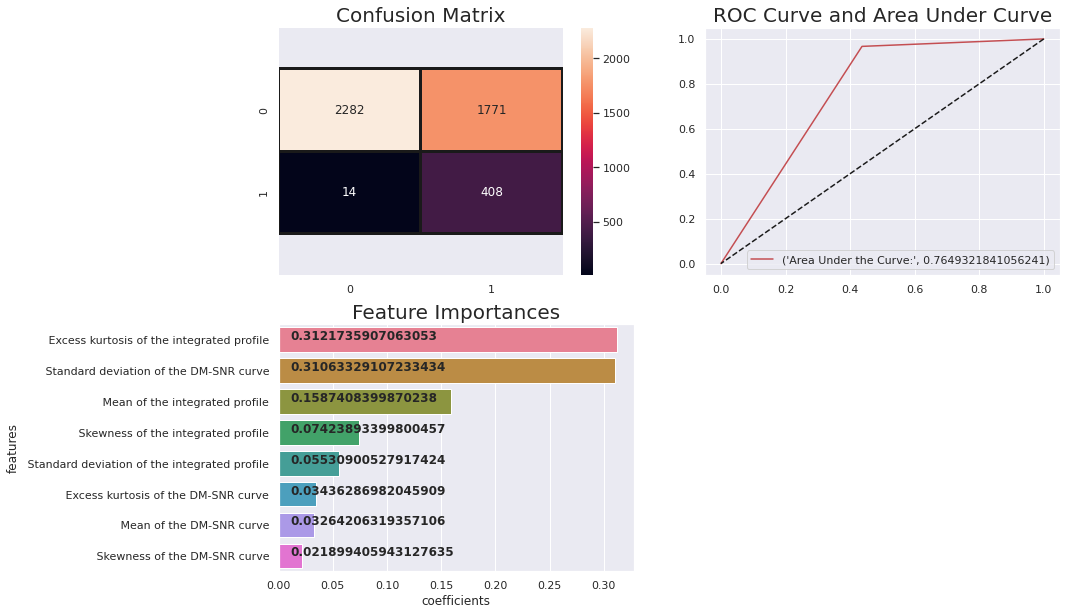

In [ ]:
# normalized data
model(ext, X_train_TN, y_train_TN, X_test, y_test, "feat")

The Extra Tree model performed similarly to the Decision tree model, almost the exact same metrics.  
Even though the normalized model is for all intents and purposes, useless, it's interesting to see the feature importances graph topped by the mean IPP feature.

### Gradient Boost

GradientBoostingClassifier()

accuracy_score: 0.9774301675977654

classification report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.99      4053
           1       0.90      0.85      0.88       422

    accuracy                           0.98      4475
   macro avg       0.94      0.92      0.93      4475
weighted avg       0.98      0.98      0.98      4475



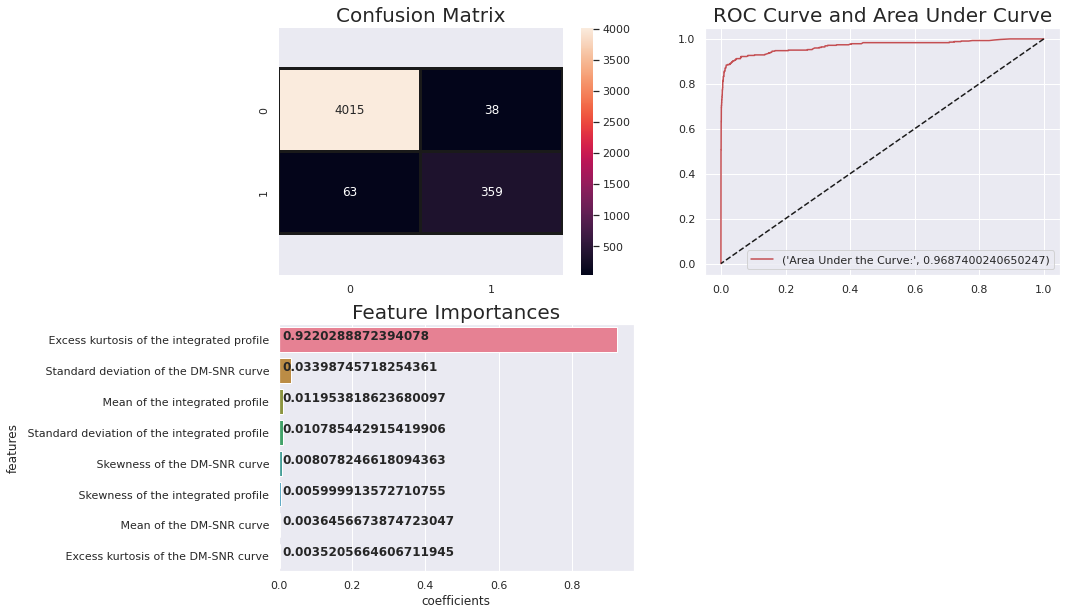

In [ ]:
# raw data
model(gb, X_train, y_train, X_test, y_test, "feat")

GradientBoostingClassifier()

accuracy_score: 0.6091620111731844

classification report:
               precision    recall  f1-score   support

           0       0.99      0.57      0.73      4053
           1       0.19      0.96      0.32       422

    accuracy                           0.61      4475
   macro avg       0.59      0.77      0.52      4475
weighted avg       0.92      0.61      0.69      4475



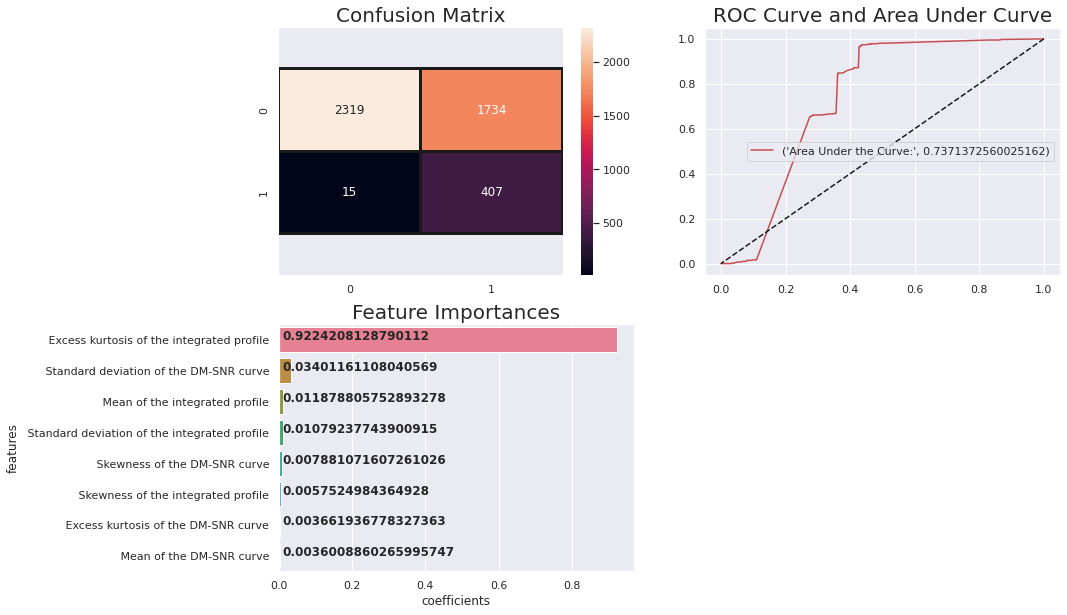

In [ ]:
# normalized data
model(gb, X_train_TN, y_train_TN, X_test, y_test, "feat")

The raw data Gradient Boost model is so far the best performing model with an accuracy score of .98, a macro avg F1 of .93, a target class F1 of .88, the lowest number of false positives and negatives out of the models run thusfar, and a AUC of .97.

### AdaBoost

AdaBoostClassifier()

accuracy_score: 0.9769832402234637

classification report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.99      4053
           1       0.92      0.82      0.87       422

    accuracy                           0.98      4475
   macro avg       0.95      0.91      0.93      4475
weighted avg       0.98      0.98      0.98      4475



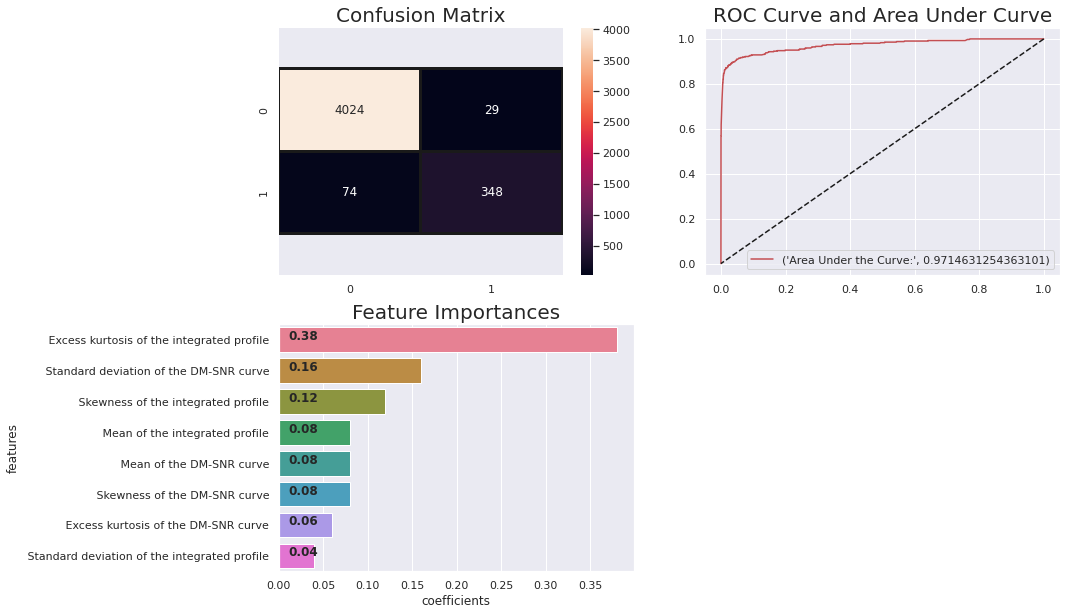

In [ ]:
# raw
model(adb, X_train, y_train, X_test, y_test, "feat")

AdaBoostClassifier()

accuracy_score: 0.6487150837988827

classification report:
               precision    recall  f1-score   support

           0       0.99      0.62      0.76      4053
           1       0.21      0.95      0.34       422

    accuracy                           0.65      4475
   macro avg       0.60      0.78      0.55      4475
weighted avg       0.92      0.65      0.72      4475



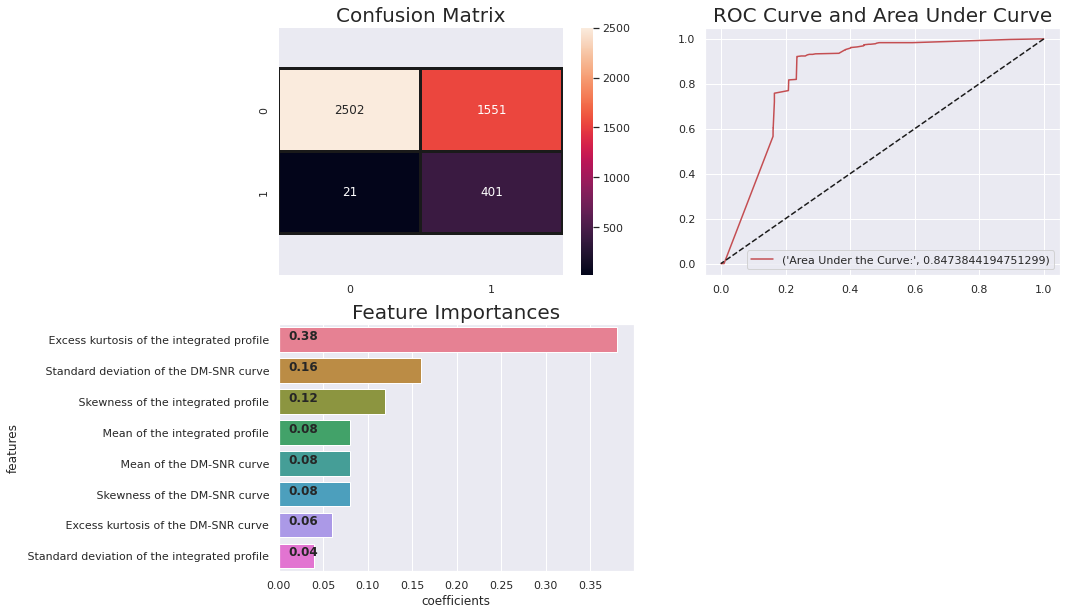

In [ ]:
# normalized data
model(adb, X_train_TN, y_train_TN, X_test, y_test, "feat")

The raw data AdaBoost model performed on level with the Gradient Boost model, which is quite well. Almost identical metrics.   

### XGBoost

In [ ]:
# testing with non-normalized data
clf = XGBClassifier(random_state=25)
clf.fit(X_train, y_train)
training_preds = clf.predict(X_train)
val_preds = clf.predict(X_test)
training_accuracy = accuracy_score(y_train, training_preds)
val_accuracy = accuracy_score(y_test, val_preds)

print("Training Accuracy: {:.4}%".format(training_accuracy * 100))
print("Validation accuracy: {:.4}%".format(val_accuracy * 100))

Training Accuracy: 99.88%
Validation accuracy: 97.72%


In [ ]:
xgbo = XGBClassifier(random_state=seed)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=25,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

accuracy_score: 0.9772067039106145

classification report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.99      4053
           1       0.92      0.83      0.87       422

    accuracy                           0.98      4475
   macro avg       0.95      0.91      0.93      4475
weighted avg       0.98      0.98      0.98      4475



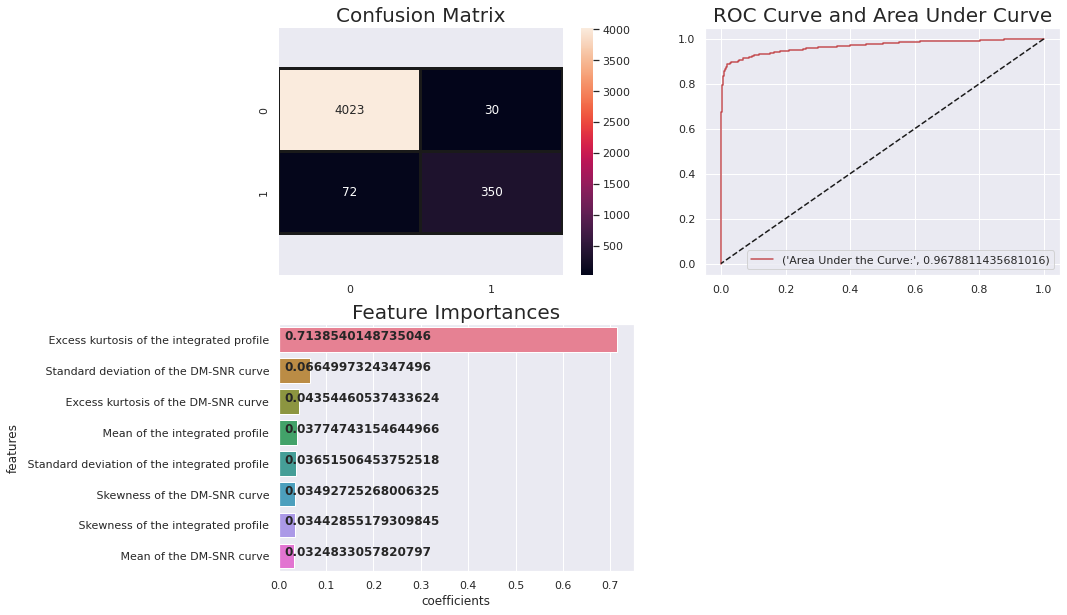

In [ ]:
# confusion matrix for XGB
model(xgbo, X_train, y_train, X_test, y_test, "feat")

### Summary of Models
Due to their horrible levels of performance, the models built off of the normalized dataset will be ignored entirely for this comparison. The table below describes the performance of the models:


| Classifier | Accuracy Score | Macro Avg. F1 Score | Target Class F1 score | False Pos | False Neg | AUC | Runtime(sec) |
| --- | --- | --- | --- | --- | --- | --- | --- |
| XGBoost | 99 | .93 | .87 | 30 | 72 | .97 | 0.673 |
| AdaBoost | 98 | .93 | .87 | 29 | 74 | .97 | 1.230 |
| Bagging Tree | 98 | .93 | .88 | 29 | 71 | .95 | 1.237 |
| Random Forest | 98 | .93 | .87 | 30 | 73 | .96 | 3.447 |
| Gradient Boost | 98 | .93 | .88 | 38 | 64 | .97 | 5.597 |
| Logistic Regression | 98 | .93 | .87 | 27 | 75 | .97 | 0.124 |
| Decision Tree | 97 | .90 | .82 | 70 | 77 | .90 | 0.221 |
| KNN | 97 | .92 | .85 | 38 | 81 | .93 | 0.043 |
| Extra Tree | 97 | .90 | .82 | 78 | 74 | .90 | 0.010 |
| Gassian Naive Bayes | 95 | .86 | .75 | 161 | 69 | .95 | 0.006 |


## Tuning Model Hyperparameters  
In this stage, I take my top 3 best performing models: XGBoost, AdaBoost, and Bagging Tree, and look to increase their performance via GridSearch to find the ideal parameters.

#### GridSearch optimization for XGBoost

In [ ]:
clf = XGBClassifier(random_state=25)

param_grid = {
    'max_depth': [20, 50, 100, 200],
    'learning_rate': [0.125, 0.25, 0.5, 1],
    'subsample': [.6, .75, .9],
    'min_child_weight': [10, 20, 30],
    'n_estimators': [10, 100, 500]
}
gridsearch_xgb = GridSearchCV(clf, param_grid, scoring='accuracy', cv=3)
gridsearch_xgb.fit(X_train, y_train)
print(f"Training Accuracy: {gridsearch_xgb.best_score_ :.2%}")
print("Validation accuracy: {:.4}%".format(val_accuracy * 100))
print("")
print(f"Optimal Parameters: {gridsearch_xgb.best_params_}")

Training Accuracy: 98.06%
Validation accuracy: 97.72%

Optimal Parameters: {'learning_rate': 0.25, 'max_depth': 20, 'min_child_weight': 20, 'n_estimators': 100, 'subsample': 0.9}


In [ ]:
xgboTuned = XGBClassifier(random_state=seed, learning_rate=0.25,
                              max_depth=20, min_child_weight=20,
                              n_estimators=100, subsample=0.9)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.25, max_delta_step=0, max_depth=20,
              min_child_weight=20, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=25,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.9,
              tree_method='exact', validate_parameters=1, verbosity=None)

accuracy_score: 0.9776536312849162

classification report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.99      4053
           1       0.91      0.84      0.88       422

    accuracy                           0.98      4475
   macro avg       0.95      0.92      0.93      4475
weighted avg       0.98      0.98      0.98      4475



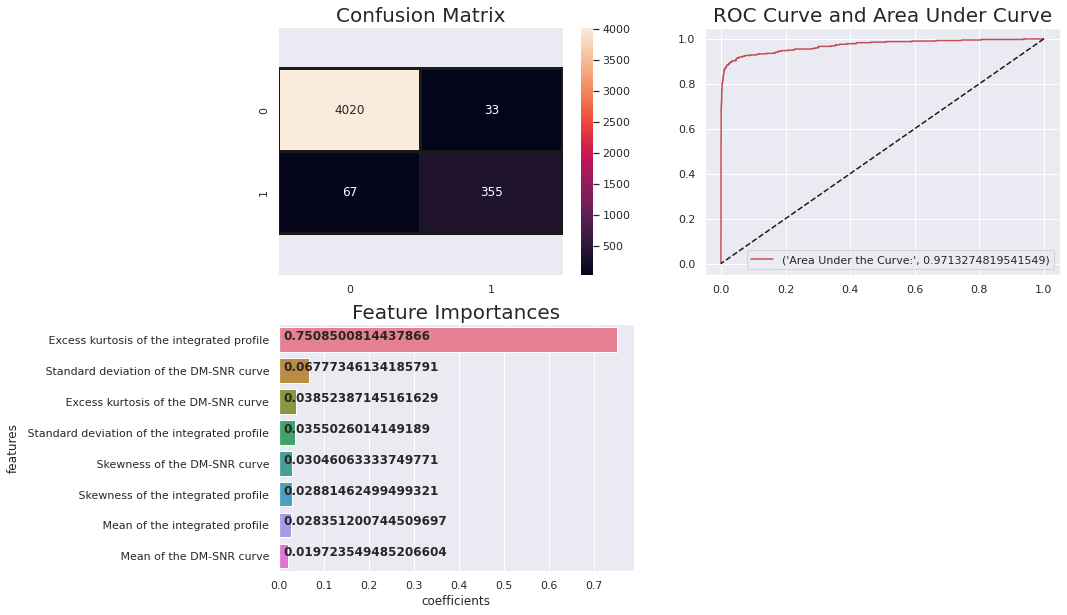

In [ ]:
model(xgboTuned, X_train, y_train, X_test, y_test, "feat")

#### GridSearch optimization for AdaBoost

In [ ]:
clf = AdaBoostClassifier()

param_grid = {
    'n_estimators': [20, 50, 100, 200],
    'learning_rate': [0.125, 0.25, 0.5, 1],
}
gridsearch_adb = GridSearchCV(clf, param_grid, scoring='accuracy', cv=3)
gridsearch_adb.fit(X_train, y_train)
print(f"Training Accuracy: {gridsearch_adb.best_score_ :.2%}")
print("Validation accuracy: {:.4}%".format(val_accuracy * 100))
print("")
print(f"Optimal Parameters: {gridsearch_adb.best_params_}")

Training Accuracy: 98.01%
Validation accuracy: 97.72%

Optimal Parameters: {'learning_rate': 0.25, 'n_estimators': 200}


In [ ]:
adbTuned = AdaBoostClassifier(learning_rate=0.25, n_estimators=200)

AdaBoostClassifier(learning_rate=0.25, n_estimators=200)

accuracy_score: 0.9758659217877095

classification report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.99      4053
           1       0.92      0.82      0.86       422

    accuracy                           0.98      4475
   macro avg       0.95      0.90      0.93      4475
weighted avg       0.98      0.98      0.98      4475



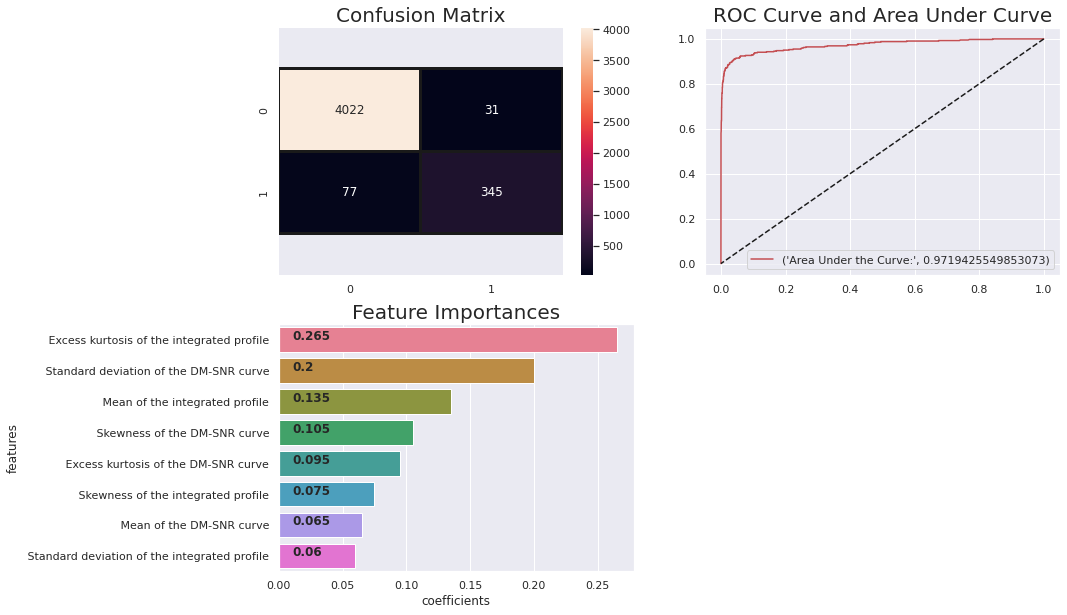

In [ ]:
model(adbTuned, X_train, y_train, X_test, y_test, "feat")

#### GridSearch optimization for Bagging Tree

In [ ]:
clf = BaggingClassifier(base_estimator=DecisionTreeClassifier(),
                        random_state=seed)

param_grid = {
    'bootstrap': [True, False],
    'bootstrap_features': [True, False],
    'n_estimators': [10, 50, 100],
    'max_samples' : [10, 100],
    'base_estimator__criterion': ['gini','entropy'],
    'base_estimator__max_features' : [0.6, 0.8, 1.0],
    'base_estimator__min_samples_leaf': [1, 3, 5, 10]
}
gridsearch_bag = GridSearchCV(clf, param_grid, scoring='accuracy', cv=3)
gridsearch_bag.fit(X_train, y_train)
print(f"Training Accuracy: {gridsearch_bag.best_score_ :.2%}")
print("Validation accuracy: {:.4}%".format(val_accuracy * 100))
print("")
print(f"Optimal Parameters: {gridsearch_bag.best_params_}")

Training Accuracy: 97.79%
Validation accuracy: 97.72%

Optimal Parameters: {'base_estimator__criterion': 'entropy', 'base_estimator__max_features': 1.0, 'base_estimator__min_samples_leaf': 1, 'bootstrap': True, 'bootstrap_features': False, 'max_samples': 100, 'n_estimators': 100}


In [ ]:
bagTuned = BaggingClassifier(base_estimator=DecisionTreeClassifier(criterion='entropy',
                                                                  max_features=1,
                                                                  min_samples_leaf=1,
                                                                  random_state=seed),
                             bootstrap=True, bootstrap_features=False,
                             max_samples=100, n_estimators=100, random_state=seed)

In [ ]:
model(bagTuned, X_train, y_train, X_test, y_test, "none")

# Interpret the Data - Conclusion

Here in the final step, I examine the findings developed by modeling and indentify important insights. As more data becomes available, this cycle can repeat and continue in a loop to build a faster, less biased, and more accurate model. For now, I'll review the models completed with the data available.  

### Model Performance (Top 3 models, comparing metrics)

These findings are presented in the following format: (tuned) base. All models scored a 97.72% Validation accuracy, supporting their resistance to overtraining.

| Classifier | Accuracy Score | Macro Avg. F1 Score | Target Class F1 score | False Pos | False Neg | AUC | Runtime(sec) |
| --- | --- | --- | --- | --- | --- | --- | --- |
| XGBoost | (98)99 | (.93).93 | (.88).87 | (33)30 | (67)72 | (.97).97 | 0.673 |
| AdaBoost | (98)98 | (.93).93 | (.86).87 | (31)29 | (77)74 | (.97).97 | 1.230 |
| Bagging Tree | (97)98 | (.91).93 | (.83).88 | (20)29 | (107)71 | (.96).95 | 1.237 |

The three best performing classifiers were XGBoost, AdaBoost, and Bagging Tree. They all were able to produce high accuracy, high validation test scores, and low numbers of type I and type II errors. XGBoost performed narrowly better than the latter two, with a higher accuracy, macro average F1 score, Target class F1 score, and AUC. All of the top 3 models scored a 97.72 in validation score, showing their resistance to overtraining. Also, the top 3 models all had similar type I and type II errors.  

Coming from a baseline model with a <20% accuracy, there was significant improvement made by dealing with class imbalances, using more robust algorithms, and tuning those algorithms to the ideal parameters.

XGBoost is the ideal model, based off of accuracy, validation, and runtime.


### Feature Importance

By far, excess kurtosis of the Integrated Pulse Profile was the most important feature for classifying these candidate stars.  

By examining the feature importance charts, we can see how impactful it was in the XGBoost and Adaboost models. The Bagging Tree classifier seems to be less one dimensional in that regard and shows a fairly high importance for Standard Deviation of the DM-SNR curve, and the Mean of the IPP.  


### EDA Summary -  Confirming Suspicions

Now to revisit my post-EDA impressions below:
By looking at the target class counts bar chart, we can clearly see there is a
large class imbalance. True positives of our target class instance only make
up 9% of the dataset.

The two features of kurtosis and skewness of the integrated pulse profile are
closely correlated, in the early stages of the modeling section, I may end up removing
one of them. I will reexamine that after doing some baseline modeling and begin
doing feature selection and engineering.   
The mean and standard deviation  of the DM-SNR curve attributes also seem to be
correlated, but again, that will be revisited in the early stages of modeling.
Also, the kurtosis and skewness of the DM-SNR curve also seem to be correlated.
Finally, the kurtosis of the integrated pulse profile seems to be fairly correlated(.79)
with our target_class. I'll continue to test this correlation and see if there is a
true, solid relationship between them.   

By comparing the means between our attributes to the target class, we can see some
possible relationships in the pointplots. It seems that the higher the mean of the
integrated pulse profile and the skewness of the the DM-SNR curve, the less likely
the candidate stars are to be actual pulsars.   
When we look at the standard deviation of the two classes compared to one another,
the higher the skewness of the DM-SNR curve also seems to suggest a higher likelihood
of being a false positive.   

None of the features follow a true normal distribution. Kurtosis and skewness of the IPP
are close to normal, but both are ever so slightly positively skewed.  
As mentioned before, I will model both the raw data and transformed & normalized data
to see if there is an increase in accuracy from normalizing these attributes.   

When we examine the scatterplots that display the relationships between the skewness
and kurtosis of the IPP and DM-SNR curves when related to the target_class, we can
make the following assumptions:   
The higher the kurtosis and skewness of the IPP, the more likely it is that the candidate star is a pulsar.   
The lower kurtosis and skewness of the DM-SNR curve, the more likely it is that the candidate star is a pulsar.   

By looking at the boxplots of the attributes, here are some brief summaries of what is shown:   
- The mean of the IPP appears to be higher for false positives.    
- The standared deviation of the IPP for the false positives appear to be slightly higher and have more upper end outliers.   
- The kurtosis of the IPP seems to be smaller/close to 0 for false positives.   
- The skewness of the IPP again is around 0 for false positives, while for actual pulsars, it is much larger.   
- The mean of the DM-SNR curve is typically higher for actual pulsars, compared to false positives.   
- The standard deviation of the DM-SNR curve is higher for actual pulsars than false positives.  
- The kurtosis of the DM-SNR curve is higher for false positives than for actual pulsars.   
- The skewness of the DM-SNR curve is significantly higher for false positives than for actual pulsars.    

Finally, we can see again in the histograms that there are no normal distributions and
none of our data is categorical.

As I had expected, the kurtosis of the IPP was strongly related to confirming a True Positive.

### Final Thoughts - Recommendations and Potential Future Work

#### Model Selection
I recommend using XGBoost. It is a faster, more robust model, capable of high levels of accuracy and validation.

#### Business Value
Overall, our model(s) performed well and could prove to be valuable assets to the field. With the ability to quickly and reliably classify candidate stars, we can more easily identify pulsars to study further.

#### Larger Dataset
For future work, I would find it beneficial to have a larger dataset, with more anomolies in it to be able to refine our model even further. Looking at other forms of radio interference and how to train our telescopes to avoid misclassification of these candidate stars would help "trim the fat" off of a larger dataset and effectively pre-process for us.

#### More Computational Power
It would be beneficial in the case of a larger dataset to be able to take advantage of a supercomputer or a distributed system to be able to efficiently process massive datasets. These things are more available in the research scenarios and professional observational astronomy labs.

#### More Complex ML / DL
I am curious to see if more advanced machine learning & deep learning techniques would yeild better results.

### References

Special thanks to Kuo Liu of the Max Planck Institute for allowing me to cite and use his work on pulsars.

[1] Kuo Liu (2017). "Introduction to Pulsar, Pulsar Timing, and measuring of Pulse Time-of-Arrivals", Max-Planck-Institut für Radioastronomie, Bonn, Germany

